# **Modélisation par régression de crête**

**API SKL** : [`Ridge`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge)

**Guide SKL** : [**Ridge regression and classification** (1.1.2)](https://scikit-learn.org/stable/modules/linear_model.html#ridge-regression-and-classification)

**Résout** : $\min_{w} || X w - y||_2^2 + \alpha ||w||_2^2$

**Complexité** : $\mathcal{O}(n p^2)$ ~ complexité OLS.

## Chargement et nettoyage des données

In [1]:
from pepper_commons import get_data
from seattle_commons import clean_dataset, drop_my_outliers
data = get_data()                                    # load data from CSV file
data, not_compliant, outliers = clean_dataset(data)  # drop outliers identified by Seattle
data, my_outliers = drop_my_outliers(data)           # drop my own outliers (18)

✔ _data loaded
✔ struct loaded


## Partition *résidentiel* vs. *non résidentiel*

In [2]:
from seattle_commons import get_family_buildings, get_business_buildings
r_data = get_family_buildings(data)                # residential subset
nr_data = get_business_buildings(data)             # non residential subset

# Expérimentation

## Config 1 : $e = f(a)$

Ensemble minimal.

$\{a : e\}$

Sous-performance par rapport à l'OLS de :
* 0,0013153405 pour la recherche en grille avec `GridSearchCV`,
* 0,155891 pour la recherche intégrée avec `RidgeCV`.

C'est assez surprenant pour supposer que la `RidgeCV` a été mal utilisée.

$R^2_{1, \text{Ridge}} \left(\{a : e\}\right)$ :
* $\mu = 0.34480934934723945$
* $\sigma = 0.17268933244956416$

$R^2_{1, \text{RidgeCV}} \left(\{a : e\}\right)$ :
* $\mu = 0.19023369020621722$
* $\sigma = 0.34521894443183665$

Rappel pour comparaison :

$R^2_{1, \text{OLS}} \left(\{a : e\}\right)$ :
* $\mu = 0.34612468985020617$
* $\sigma = 0.15269182507734183$

#### Jeu de données

In [3]:
config_name = "{a : e}"

from seattle_commons import get_ml_data_cfg
ml_data = get_ml_data_cfg(data, config_name); # display(ml_data)

#### Visualisation

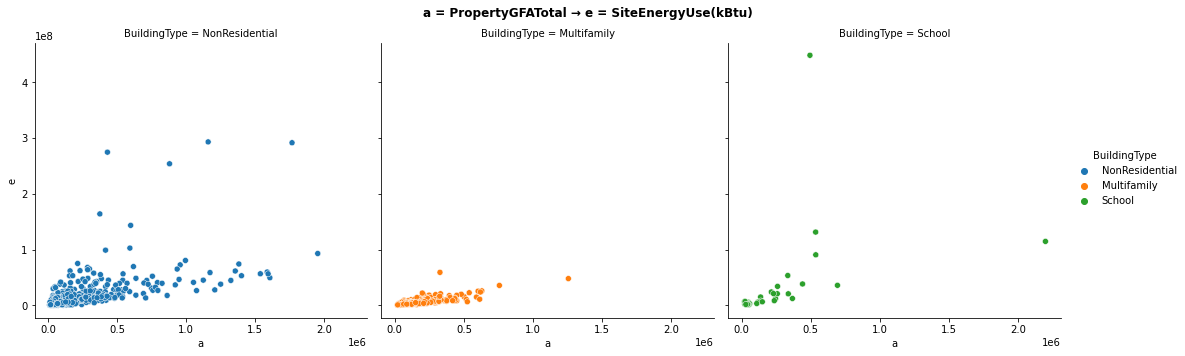

In [9]:
from seattle_commons import get_abstract_btype, plot_ml_data_all
btype = get_abstract_btype(data)
plot_ml_data_all(ml_data, btype)

#### Vérifications

In [10]:
from seattle_commons import check_data
check_data(ml_data)

✔ All coefficients are positive or null
✔ No NA coefficient


#### Partition

In [4]:
# Features / target split
from seattle_commons import features_target_split
X, y = features_target_split(ml_data)

# Train / test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

#### Entraînement

##### Recherche en grille externe

In [5]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
lr = linear_model.LinearRegression()
lr_reg = lr.fit(X_train, y_train)
baseline_err = cross_val_score(lr_reg, X_train, y_train, cv=5).mean()
print(baseline_err)

0.2590294601579844


In [ ]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from pepper_commons import print_title, print_subtitle, bold
import time
from pepper_skl_commons import Dataset, get_baseline_err, search_best_params, get_best_params

Xy = X_train, X_test, y_train, y_test
model = linear_model.Ridge()
param_grid = {
    'alpha': np.logspace(9, 15, 100),
    'solver': ['auto', 'svd', 'sparse_cg', 'sag', 'saga'], # , 'cholesky', 'lsqr', 'lbfgs'
    'random_state': [42]
}

(
    best_estimator,
    best_params,
    best_score,
    best_index,
    scorer,
    cv_res
) = get_best_params(Xy, model, param_grid, baseline_err, cv=5, verbose=False)

In [8]:
print('best', bold('estimator'), ':', best_estimator)
print('best', bold('params'), ':', best_params)
print('best', bold('score'), ':', best_score)
print('best', bold('index'), ':', best_index)
print(bold('scorer'), ':', scorer)

print(' train', bold('score'), ':', best_estimator.score(X_train, y_train))
print('  test', bold('score'), ':', best_estimator.score(X_test, y_test))
print('global', bold('score'), ':', best_estimator.score(X, y))

print('best', bold('estimator'), 'intercept :', best_estimator.intercept_)
print('best', bold('estimator'), '    coefs :', best_estimator.coef_)

from seattle_commons import show_ols_scores # TODO : à renommer
show_ols_scores(best_estimator, X, y, cv=3)

best estimator : Ridge(alpha=10000000000000.0, random_state=42, solver='saga')
best params : {'alpha': 10000000000000.0, 'random_state': 42, 'solver': 'saga'}
best score : 0.5206422771668267
best index : 334
scorer : <function _passthrough_scorer at 0x000001D792EEA790>
 train score : 0.4494244155313608
  test score : 0.2997739234143978
global score : 0.3321818670175878
best estimator intercept : 812095.913067217
best estimator     coefs : [45.36521435]
cv scores : [0.21494213 0.58886104 0.23062488]
mean scores : 0.34480934934723945
std scores : 0.17268933244956416


In [9]:
print_subtitle('Cross validated results :')  # TODO : mieux vaut un graphique + une sauvegarde
display(cv_res.sort_values(by='rank_test_score'))


Cross validated results :


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_random_state,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
334,0.003398,0.000491,0.001600,0.000489,10000000000000.0,42,saga,"{'alpha': 10000000000000.0, 'random_state': 42...",0.387802,0.712856,0.509266,0.742343,0.250944,0.520642,0.187942,1
333,0.003800,0.000749,0.002201,0.000399,10000000000000.0,42,sag,"{'alpha': 10000000000000.0, 'random_state': 42...",0.387371,0.712852,0.509081,0.742916,0.250915,0.520627,0.188148,2
331,0.002600,0.000490,0.001801,0.000399,10000000000000.0,42,svd,"{'alpha': 10000000000000.0, 'random_state': 42...",0.387327,0.712851,0.509132,0.742559,0.250951,0.520564,0.188059,3
332,0.002399,0.000492,0.001819,0.000412,10000000000000.0,42,sparse_cg,"{'alpha': 10000000000000.0, 'random_state': 42...",0.387327,0.712851,0.509132,0.742559,0.250951,0.520564,0.188059,3
330,0.002583,0.000996,0.001799,0.000400,10000000000000.0,42,auto,"{'alpha': 10000000000000.0, 'random_state': 42...",0.387327,0.712851,0.509132,0.742559,0.250951,0.520564,0.188059,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,0.002398,0.000492,0.002003,0.000631,1000000000000000.0,42,svd,"{'alpha': 1000000000000000.0, 'random_state': ...",0.013946,0.029472,-0.001864,0.011442,-0.004344,0.009730,0.012190,496
495,0.003400,0.000490,0.002401,0.000491,1000000000000000.0,42,auto,"{'alpha': 1000000000000000.0, 'random_state': ...",0.013946,0.029472,-0.001864,0.011442,-0.004344,0.009730,0.012190,496
497,0.002196,0.000747,0.001601,0.000489,1000000000000000.0,42,sparse_cg,"{'alpha': 1000000000000000.0, 'random_state': ...",0.013946,0.029472,-0.001864,0.011442,-0.004344,0.009730,0.012190,496
499,0.003201,0.000981,0.001999,0.000001,1000000000000000.0,42,saga,"{'alpha': 1000000000000000.0, 'random_state': ...",0.013947,0.029469,-0.001864,0.011442,-0.004344,0.009730,0.012189,499


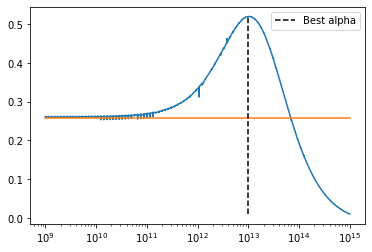

In [10]:
import matplotlib.pyplot as plt
ax = plt.gca()
ax.plot(cv_res.param_alpha, cv_res.mean_test_score, [10**9, 10**15], [baseline_err, baseline_err])
ax.set_xscale('log')
ax.vlines(
    best_params["alpha"],
    cv_res.mean_test_score.min(),
    cv_res.mean_test_score.max(),
    color="black",
    linestyle="--",
    label="Best alpha",
)
plt.legend()
plt.show()

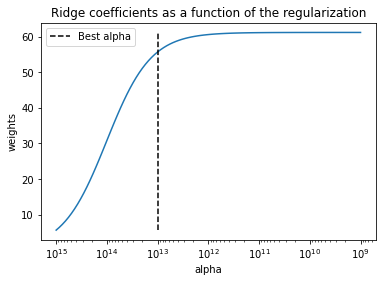

In [11]:
# cf. https://scikit-learn.org/stable/auto_examples/linear_model/plot_ridge_path.html
n_alphas = 100
alphas = np.logspace(9, 15, n_alphas)

coefs = []
for a in alphas:
    ridge = linear_model.Ridge(alpha=a, fit_intercept=False)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)

coefs = np.ravel(coefs)

ax = plt.gca()

ax.plot(alphas, coefs)
ax.vlines(
    best_params["alpha"],
    coefs.min(),
    coefs.max(),
    color="black",
    linestyle="--",
    label="Best alpha",
)

ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Ridge coefficients as a function of the regularization")
plt.axis("tight")
plt.legend()

plt.show()

##### Recherche en grille intégrée

In [13]:
reg = linear_model.RidgeCV(alphas=np.logspace(9, 15, 100))
reg.fit(X_train, y_train)

print('best', bold('alpha'), ':', reg.alpha_)
print('best', bold('n-MSE score'), ':', reg.best_score_)
print(' train', bold('r2 score'), ':', reg.score(X_train, y_train))
print('  test', bold('r2 score'), ':', reg.score(X_test, y_test))
print('global', bold('r2 score'), ':', reg.score(X, y))

from seattle_commons import show_ols_scores # TODO : à renommer
show_ols_scores(reg, X, y, cv=15)

# display(reg.cv_values_)


best alpha : 811130830789.6888
best n-MSE score : -124145274560172.9
 train r2 score : 0.512603053107153
  test r2 score : 0.31611172414774213
global r2 score : 0.35863145323156576
cv scores : [ 0.20682638  0.2888669   0.39068874 -0.2968287   0.07102996  0.47254208
  0.79265775  0.47467854  0.38005514 -0.35680903  0.36380421 -0.56721243
  0.29220965  0.19110676  0.17360747]
mean scores : 0.19181489393699794
std scores : 0.34398885978005816


## Config 4 : passage au log

$\{\log(a):\log(e)\}$

Les performances sont les mêmes que celles de la régression OLS.

Ceci s'explique par un $\alpha \sim 0$ : le ridge se comporte alors comme l'OLS et produit évidemment les mêmes coefficients $w_0 = 1$ et $w_1 = 3$, i.e. $\log(e) \sim 1 + 3\log(a)$ i.e. $e \sim K a^3$

$R^2_{4, \text{Ridge}} \left(\{\log(a):\log(e)\}\right)$
* $\mu = 0.5682599164701722$
* $\sigma = 0.06111243656145695$

Rappel pour comparaison :

$R^2_{4, \text{OLS}} \left(\{\log(a):\log(e)\}\right)$
* $\mu = 0.5682704287868149$
* $\sigma = 0.06114819172081779$

#### Jeu de données

In [15]:
config_name = "{log(a) : log(e)}"

from seattle_commons import get_ml_data_cfg
ml_data = get_ml_data_cfg(data, config_name); # display(ml_data)

#### Visualisation

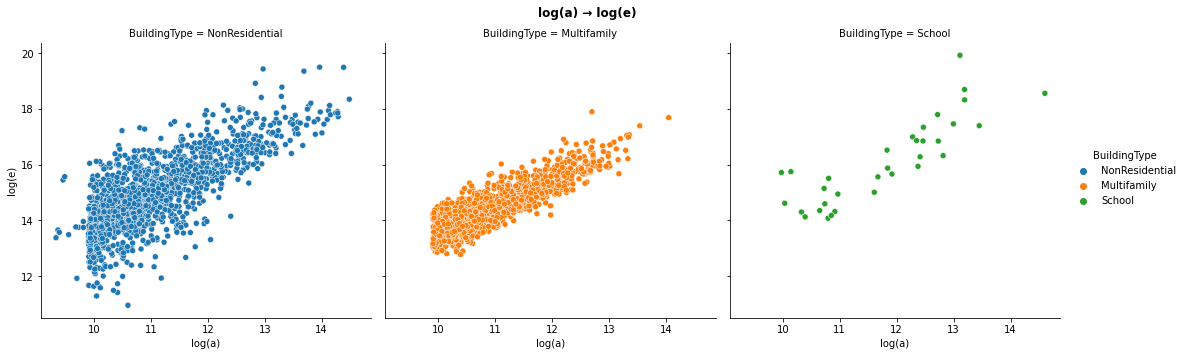

In [16]:
from seattle_commons import get_abstract_btype, plot_ml_data_all
btype = get_abstract_btype(data)
plot_ml_data_all(ml_data, btype)

#### Vérifications

In [17]:
from seattle_commons import check_data
check_data(ml_data)

✔ All coefficients are positive or null
✔ No NA coefficient


#### Partition

In [18]:
from seattle_commons import features_target_split
X, y = features_target_split(ml_data)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

#### Entraînement

##### Recherche en grille externe

In [19]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
lr = linear_model.LinearRegression()
lr_reg = lr.fit(X_train, y_train)
baseline_err = cross_val_score(lr_reg, X_train, y_train, cv=5).mean()
print(baseline_err)

0.6614606776188937


In [ ]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from pepper_commons import print_title, print_subtitle, bold
import time
from pepper_skl_commons import Dataset, get_baseline_err, search_best_params, get_best_params

Xy = X_train, X_test, y_train, y_test
model = linear_model.Ridge()
param_grid = {
    'alpha': np.logspace(-1, 1, 100),
    'solver': ['auto', 'svd', 'sparse_cg', 'sag', 'saga'], # , 'cholesky', 'lsqr', 'lbfgs'
    'random_state': [42]
}

(
    best_estimator,
    best_params,
    best_score,
    best_index,
    scorer,
    cv_res
) = get_best_params(Xy, model, param_grid, baseline_err, cv=5, verbose=False)

In [22]:
print('best', bold('estimator'), ':', best_estimator)
print('best', bold('params'), ':', best_params)
print('best', bold('score'), ':', best_score)
print('best', bold('index'), ':', best_index)
print(bold('scorer'), ':', scorer)

print(' train', bold('score'), ':', best_estimator.score(X_train, y_train))
print('  test', bold('score'), ':', best_estimator.score(X_test, y_test))
print('global', bold('score'), ':', best_estimator.score(X, y))

print('best', bold('estimator'), 'intercept :', best_estimator.intercept_)
print('best', bold('estimator'), '    coefs :', best_estimator.coef_)

from seattle_commons import show_ols_scores # TODO : à renommer
show_ols_scores(best_estimator, X, y, cv=3)

best estimator : Ridge(alpha=1.291549665014884, random_state=42, solver='sag')
best params : {'alpha': 1.291549665014884, 'random_state': 42, 'solver': 'sag'}
best score : 0.6618940333252662
best index : 278
scorer : <function _passthrough_scorer at 0x000001D792EEA790>
 train score : 0.6719275289331945
  test score : 0.6366732109250308
global score : 0.6451879738800761
best estimator intercept : 3.0944967206545755
best estimator     coefs : [1.05089656]
cv scores : [0.64092131 0.49163136 0.57153582]
mean scores : 0.5680294979630448
std scores : 0.060997779454520035


In [23]:
print_subtitle('Cross validated results :')  # TODO : mieux vaut un graphique + une sauvegarde
display(cv_res.sort_values(by='rank_test_score'))


Cross validated results :


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_random_state,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
278,0.003199,0.000981,0.002000,0.000632,1.29155,42,sag,"{'alpha': 1.291549665014884, 'random_state': 4...",0.623105,0.627233,0.607519,0.717328,0.734285,0.661894,0.052870,1
283,0.003598,0.000489,0.002001,0.000633,1.353048,42,sag,"{'alpha': 1.3530477745798075, 'random_state': ...",0.623107,0.627251,0.607509,0.717328,0.734243,0.661887,0.052857,2
288,0.003798,0.001165,0.002001,0.000633,1.417474,42,sag,"{'alpha': 1.4174741629268055, 'random_state': ...",0.623109,0.627269,0.607499,0.717327,0.734199,0.661881,0.052845,3
293,0.003002,0.000634,0.001597,0.000491,1.484968,42,sag,"{'alpha': 1.484968262254465, 'random_state': 4...",0.623111,0.627288,0.607489,0.717327,0.734154,0.661874,0.052832,4
298,0.004000,0.000895,0.001800,0.000747,1.555676,42,sag,"{'alpha': 1.5556761439304723, 'random_state': ...",0.623113,0.627308,0.607478,0.717327,0.734108,0.661867,0.052818,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328,0.004198,0.000399,0.002601,0.000489,2.056512,42,sag,"{'alpha': 2.0565123083486516, 'random_state': ...",0.623126,0.627451,0.607411,0.717324,0.721066,0.659276,0.049391,496
353,0.002800,0.000400,0.001402,0.000489,2.595024,42,sag,"{'alpha': 2.5950242113997373, 'random_state': ...",0.623140,0.627603,0.605897,0.717320,0.722260,0.659244,0.049989,497
348,0.004604,0.000493,0.001597,0.000487,2.477076,42,sag,"{'alpha': 2.4770763559917115, 'random_state': ...",0.623137,0.627569,0.605874,0.717321,0.722017,0.659184,0.049937,498
343,0.003800,0.000399,0.002000,0.000001,2.364489,42,sag,"{'alpha': 2.3644894126454084, 'random_state': ...",0.623134,0.627538,0.605853,0.717322,0.721775,0.659124,0.049886,499


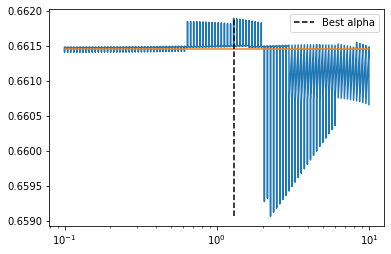

In [24]:
import matplotlib.pyplot as plt
ax = plt.gca()
ax.plot(cv_res.param_alpha, cv_res.mean_test_score, [10**-1, 10**1], [baseline_err, baseline_err])
ax.set_xscale('log')
ax.vlines(
    best_params["alpha"],
    cv_res.mean_test_score.min(),
    cv_res.mean_test_score.max(),
    color="black",
    linestyle="--",
    label="Best alpha",
)
plt.legend()
plt.show()

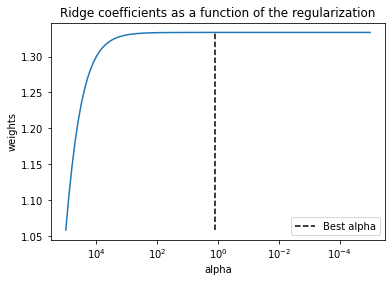

In [25]:
# cf. https://scikit-learn.org/stable/auto_examples/linear_model/plot_ridge_path.html
n_alphas = 100
alphas = np.logspace(-5, 5, n_alphas)

coefs = []
for a in alphas:
    ridge = linear_model.Ridge(alpha=a, fit_intercept=False)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)

coefs = np.ravel(coefs)

ax = plt.gca()

ax.plot(alphas, coefs)
ax.vlines(
    best_params["alpha"],
    coefs.min(),
    coefs.max(),
    color="black",
    linestyle="--",
    label="Best alpha",
)

ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Ridge coefficients as a function of the regularization")
plt.axis("tight")
plt.legend()

plt.show()

##### Recherche en grille intégrée

In [26]:
reg = linear_model.RidgeCV(alphas=np.logspace(-5, 15, 100)) #, store_cv_values=True)
reg.fit(X_train, y_train)

print('best', bold('alpha'), ':', reg.alpha_)
print('best', bold('n-MSE score'), ':', reg.best_score_)
print(' train', bold('r2 score'), ':', reg.score(X_train, y_train))
print('  test', bold('r2 score'), ':', reg.score(X_test, y_test))
print('global', bold('r2 score'), ':', reg.score(X, y))

from seattle_commons import show_ols_scores # TODO : à renommer
show_ols_scores(reg, X, y, cv=3)

# display(reg.cv_values_)


best alpha : 0.04328761281083057
best n-MSE score : -0.40627685071260666
 train r2 score : 0.6719276696001698
  test r2 score : 0.6366695592668886
global r2 score : 0.6451852214884166
cv scores : [0.64143151 0.49184281 0.57150544]
mean scores : 0.5682599164701722
std scores : 0.06111243656145695


## Config. 9 : contribution du score ENERGYSTAR

$\{n_\star, \log(a):\log(e)\}$

Même interprétation que précédemment, le Ridge non pénalisé revient à l'OLS.

$R^2_{9, \text{Ridge}} \left(\{n_\star, \log(a) :\log(e)\}\right)$:
* $\mu = 0.6166516138510613$
* $\sigma = 0.0599534988115941$

Rappels pour comparaison :

$R^2_{4, \text{Ridge}} \left(\{\log(a):\log(e)\}\right)$
* $\mu = 0.5682599164701722$
* $\sigma = 0.06111243656145695$

$R^2_{9, \text{OLS}} \left(\{n_\star, \log(a) :\log(e)\}\right)$:
* $\mu = 0.616668067176413$
* $\sigma = 0.059980161457964365$

$R^2_{4, \text{OLS}} \left(\{\log(a):\log(e)\}\right)$:
* $\mu = 0.5682704287868149$
* $\sigma = 0.06114819172081779$

#### Jeu de données

In [91]:
config_name = "{n_★, log(a) : log(e)}"

from seattle_commons import get_ml_data_cfg
ml_data = get_ml_data_cfg(data, config_name); # display(ml_data)

,star_score,log(a),log(e)
id,,,
1,60.0,11.390012,15.793246
2,61.0,11.547964,15.942305
3,43.0,13.770628,18.100297
5,56.0,11.023861,15.731636
8,75.0,12.075850,16.466822
...,...,...,...
50221,72.0,9.812523,13.745176
50223,72.0,9.680344,13.764508
50224,72.0,9.484709,15.567471


#### Vérifications

In [92]:
from seattle_commons import check_data
check_data(ml_data)

✔ All coefficients are positive or null
✔ No NA coefficient


#### Partition

In [93]:
from seattle_commons import features_target_split
X, y = features_target_split(ml_data)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

#### Entraînement

##### Recherche en grille externe

In [94]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
lr = linear_model.LinearRegression()
lr_reg = lr.fit(X_train, y_train)
baseline_err = cross_val_score(lr_reg, X_train, y_train, cv=5).mean()
print(baseline_err)

0.6971301496397384


In [95]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from pepper_commons import print_title, print_subtitle, bold
import time
from pepper_skl_commons import Dataset, get_baseline_err, search_best_params, get_best_params

Xy = X_train, X_test, y_train, y_test
model = linear_model.Ridge()
min_alpha_log = -1
max_alpha_log = 1
n_alphas = 100

param_grid = {
    'alpha': np.logspace(min_alpha_log, max_alpha_log, n_alphas),
    'solver': ['auto', 'svd', 'sparse_cg', 'sag', 'saga', 'cholesky', 'lsqr'], #, 'lbfgs'
    'random_state': [42]
}

"""best_estimator = best_params = best_score = best_index = scorer = cv_res = None
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")"""
(
    best_estimator,
    best_params,
    best_score,
    best_index,
    scorer,
    cv_res
) = get_best_params(Xy, model, param_grid, baseline_err, cv=5, verbose=False)

In [96]:
print('best', bold('estimator'), ':', best_estimator)
print('best', bold('params'), ':', best_params)
print('best', bold('score'), ':', best_score)
print('best', bold('index'), ':', best_index)
print(bold('scorer'), ':', scorer)

print(' train', bold('score'), ':', best_estimator.score(X_train, y_train))
print('  test', bold('score'), ':', best_estimator.score(X_test, y_test))
print('global', bold('score'), ':', best_estimator.score(X, y))

print('best', bold('estimator'), 'intercept :', best_estimator.intercept_)
print('best', bold('estimator'), '    coefs :', best_estimator.coef_)

from seattle_commons import show_ols_scores # TODO : à renommer
show_ols_scores(best_estimator, X, y, cv=3)

best estimator : Ridge(alpha=0.8497534359086445, random_state=42, solver='sag')
best params : {'alpha': 0.8497534359086445, 'random_state': 42, 'solver': 'sag'}
best score : 0.6972275562135083
best index : 325
scorer : <function _passthrough_scorer at 0x00000204CF173040>
 train score : 0.7062317415905045
  test score : 0.6785518138094782
global score : 0.6852542040394657
best estimator intercept : [3.66622516]
best estimator     coefs : [[-0.0086356   1.05327798]]
cv scores : [0.68337418 0.53771116 0.62393953]
mean scores : 0.6150082900256783
std scores : 0.05980108246284512


In [97]:
print_subtitle('Cross validated results :')  # TODO : mieux vaut un graphique + une sauvegarde
display(cv_res.sort_values(by='rank_test_score'))


Cross validated results :


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_random_state,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
325,0.003999,0.000002,0.002001,0.000002,0.849753,42,sag,"{'alpha': 0.8497534359086445, 'random_state': ...",0.661563,0.678026,0.666858,0.729977,0.749713,0.697228,0.035750,1
332,0.007793,0.000971,0.003199,0.000400,0.890215,42,sag,"{'alpha': 0.8902150854450388, 'random_state': ...",0.661566,0.678033,0.666861,0.729979,0.749698,0.697228,0.035744,2
318,0.004598,0.000490,0.001803,0.000401,0.811131,42,sag,"{'alpha': 0.8111308307896873, 'random_state': ...",0.661560,0.678020,0.666855,0.729976,0.749727,0.697228,0.035756,3
339,0.004806,0.000749,0.002393,0.000495,0.932603,42,sag,"{'alpha': 0.9326033468832199, 'random_state': ...",0.661569,0.678041,0.666865,0.729981,0.749683,0.697228,0.035738,4
311,0.004198,0.000400,0.002202,0.000400,0.774264,42,sag,"{'alpha': 0.7742636826811272, 'random_state': ...",0.661557,0.678013,0.666852,0.729974,0.749741,0.697228,0.035761,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669,0.008200,0.001938,0.003209,0.000759,8.302176,42,saga,"{'alpha': 8.302175681319747, 'random_state': 4...",0.662075,0.679757,0.667410,0.729990,0.744667,0.696780,0.033920,696
676,0.006800,0.001940,0.002600,0.001199,8.69749,42,saga,"{'alpha': 8.697490026177835, 'random_state': 4...",0.662076,0.679791,0.667415,0.729975,0.744510,0.696754,0.033868,697
683,0.006807,0.001720,0.002600,0.000798,9.111628,42,saga,"{'alpha': 9.111627561154895, 'random_state': 4...",0.662077,0.679826,0.667419,0.729959,0.744345,0.696725,0.033814,698
690,0.006399,0.000802,0.002601,0.000489,9.545485,42,saga,"{'alpha': 9.545484566618342, 'random_state': 4...",0.662077,0.679862,0.667378,0.729940,0.743937,0.696639,0.033699,699


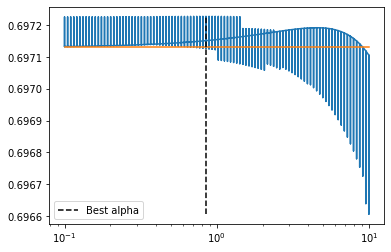

In [98]:
import matplotlib.pyplot as plt
ax = plt.gca()
ax.plot(cv_res.param_alpha, cv_res.mean_test_score,
        [10**min_alpha_log, 10**max_alpha_log], [baseline_err, baseline_err])
ax.set_xscale('log')
ax.vlines(
    best_params["alpha"],
    cv_res.mean_test_score.min(),
    cv_res.mean_test_score.max(),
    color="black",
    linestyle="--",
    label="Best alpha",
)
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


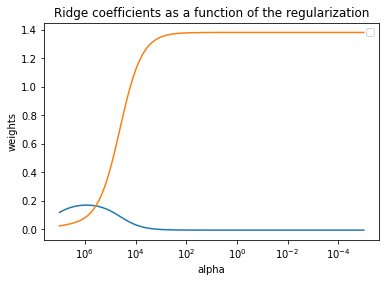

In [99]:
# cf. https://scikit-learn.org/stable/auto_examples/linear_model/plot_ridge_path.html
alphas = np.logspace(-5, 7, n_alphas)

coefs = []
for a in alphas:
    ridge = linear_model.Ridge(alpha=a, fit_intercept=False)
    ridge.fit(X, y)
    coefs.append(ridge.coef_[0])

#coefs = np.vstack(coefs)
#flat_coefs = np.ravel(coefs)
#display(coefs)


ax = plt.gca()
ax.plot(alphas, coefs)
"""ax.vlines(
    best_params["alpha"],
    #flat_coefs.min(),
    #flat_coefs.max(),
    color="black",
    linestyle="--",
    label="Best alpha",
)"""

ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Ridge coefficients as a function of the regularization")
plt.axis("tight")
plt.legend()

plt.show()

In [ ]:
print_subtitle('Cross validated results :')  # TODO : mieux vaut un graphique + une sauvegarde
display(cv_res.sort_values(by='rank_test_score'))


Cross validated results :


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_random_state,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
278,0.003201,0.000748,0.002462,0.000399,1.29155,42,sag,"{'alpha': 1.291549665014884, 'random_state': 4...",0.623105,0.627233,0.607519,0.717328,0.734285,0.661894,0.052870,1
283,0.004121,0.000642,0.002612,0.000478,1.353048,42,sag,"{'alpha': 1.3530477745798075, 'random_state': ...",0.623107,0.627251,0.607509,0.717328,0.734243,0.661887,0.052857,2
288,0.003199,0.000748,0.002290,0.000725,1.417474,42,sag,"{'alpha': 1.4174741629268055, 'random_state': ...",0.623109,0.627269,0.607499,0.717327,0.734199,0.661881,0.052845,3
293,0.003328,0.000987,0.002000,0.000633,1.484968,42,sag,"{'alpha': 1.484968262254465, 'random_state': 4...",0.623111,0.627288,0.607489,0.717327,0.734154,0.661874,0.052832,4
298,0.003898,0.000327,0.002601,0.000487,1.555676,42,sag,"{'alpha': 1.5556761439304723, 'random_state': ...",0.623113,0.627308,0.607478,0.717327,0.734108,0.661867,0.052818,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328,0.003942,0.000217,0.002944,0.000438,2.056512,42,sag,"{'alpha': 2.0565123083486516, 'random_state': ...",0.623126,0.627451,0.607411,0.717324,0.721066,0.659276,0.049391,496
353,0.003393,0.000494,0.002287,0.000396,2.595024,42,sag,"{'alpha': 2.5950242113997373, 'random_state': ...",0.623140,0.627603,0.605897,0.717320,0.722260,0.659244,0.049989,497
348,0.003840,0.001044,0.001600,0.000801,2.477076,42,sag,"{'alpha': 2.4770763559917115, 'random_state': ...",0.623137,0.627569,0.605874,0.717321,0.722017,0.659184,0.049937,498
343,0.004070,0.000570,0.002613,0.000370,2.364489,42,sag,"{'alpha': 2.3644894126454084, 'random_state': ...",0.623134,0.627538,0.605853,0.717322,0.721775,0.659124,0.049886,499


##### Recherche en grille intégrée

In [100]:
reg = linear_model.RidgeCV(alphas=np.logspace(-5, 15, 100)) #, store_cv_values=True)
reg.fit(X_train, y_train)

print('best', bold('alpha'), ':', reg.alpha_)
print('best', bold('n-MSE score'), ':', reg.best_score_)
print(' train', bold('r2 score'), ':', reg.score(X_train, y_train))
print('  test', bold('r2 score'), ':', reg.score(X_test, y_test))
print('global', bold('r2 score'), ':', reg.score(X, y))

from seattle_commons import show_ols_scores # TODO : à renommer
show_ols_scores(reg, X, y, cv=3)

# display(reg.cv_values_)


best alpha : 0.1747528400007683
best n-MSE score : -0.36454964967804127
 train r2 score : 0.7062700409592646
  test r2 score : 0.6786308641053663
global r2 score : 0.6853235724179032
cv scores : [0.68380205 0.53824619 0.6279066 ]
mean scores : 0.6166516138510613
std scores : 0.0599534988115941


## Config 12 : réintroduction de `ptype`

$\{t_p, \log(a) : \log(e)\}$

Amélioration négligeable par rapport à la régression OLS.

$R^2_{12, \text{Ridge}} \left(\{t_p, \log(a) : \log(e)\}\right)$ :
* $\mu = 0.7213922225403219$
* $\sigma = 0.042369991634988$

Rappel pour comparaison :

$R^2_{12, \text{OLS}} \left(\{t_p, \log(a) : \log(e)\}\right)$ :
* $\mu = 0.7210437373349693$
* $\sigma = 0.04229253973342958$

#### Jeu de données

In [46]:
config_name = "{t_p, log(a) : log(e)}"

from seattle_commons import get_ml_data_cfg
ml_data = get_ml_data_cfg(data, config_name); # display(ml_data)

#### Vérifications

In [47]:
from seattle_commons import check_data
check_data(ml_data)

✔ All coefficients are positive or null
✔ No NA coefficient


#### Partition

In [48]:
from seattle_commons import features_target_split
X, y = features_target_split(ml_data)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

#### Entraînement

##### Recherche en grille externe

In [49]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    lr = linear_model.LinearRegression()
    lr_reg = lr.fit(X_train, y_train)
    baseline_err = cross_val_score(lr_reg, X_train, y_train, cv=5).mean()
    print(baseline_err)

0.7578648293566047


In [ ]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from pepper_commons import print_title, print_subtitle, bold
import time
from pepper_skl_commons import Dataset, get_baseline_err, search_best_params, get_best_params

Xy = X_train, X_test, y_train, y_test
model = linear_model.Ridge()
min_alpha_log = -1
max_alpha_log = 1
n_alphas = 100

param_grid = {
    'alpha': np.logspace(min_alpha_log, max_alpha_log, n_alphas),
    'solver': ['auto', 'svd', 'sparse_cg', 'sag', 'saga', 'cholesky', 'lsqr'], #, 'lbfgs'
    'random_state': [42]
}

best_estimator = best_params = best_score = best_index = scorer = cv_res = None
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    (
        best_estimator,
        best_params,
        best_score,
        best_index,
        scorer,
        cv_res
    ) = get_best_params(Xy, model, param_grid, baseline_err, cv=5, verbose=False)

In [51]:
import warnings
with warnings.catch_warnings():
    print('best', bold('estimator'), ':', best_estimator)
    print('best', bold('params'), ':', best_params)
    print('best', bold('score'), ':', best_score)
    print('best', bold('index'), ':', best_index)
    print(bold('scorer'), ':', scorer)

    print(' train', bold('score'), ':', best_estimator.score(X_train, y_train))
    print('  test', bold('score'), ':', best_estimator.score(X_test, y_test))
    print('global', bold('score'), ':', best_estimator.score(X, y))

    print('best', bold('estimator'), 'intercept :', best_estimator.intercept_)
    print('best', bold('estimator'), '    coefs :', best_estimator.coef_)

    from seattle_commons import show_ols_scores # TODO : à renommer
    show_ols_scores(best_estimator, X, y, cv=3)

best estimator : Ridge(alpha=0.9326033468832199, random_state=42)
best params : {'alpha': 0.9326033468832199, 'random_state': 42, 'solver': 'auto'}
best score : 0.7627963523748222
best index : 336
scorer : <function _passthrough_scorer at 0x000001D792EEA790>
 train score : 0.7888940912280515
  test score : 0.7564861711006079
global score : 0.7642708897005015
best estimator intercept : 4.490692197825608
best estimator     coefs : [-5.41121731e-01 -4.72237171e-01 -3.85717230e-02  1.90186871e-01
 -6.43470049e-01  7.81067034e-04 -2.49242751e-01 -6.38413224e-02
 -6.71955648e-02  2.49407695e-01 -3.56826149e-01 -8.27634105e-01
 -1.25397854e-01 -2.71200137e-02  2.89549762e-01  1.17434250e+00
 -1.25440648e+00 -8.36355564e-02 -2.46508582e-02  7.70497441e-02
  8.51025600e-01  8.26222561e-01  1.11678553e+00  9.48387700e-01]
cv scores : [0.76598839 0.66422732 0.73391351]
mean scores : 0.7213764061011595
std scores : 0.042479119007540284


In [52]:
print_subtitle('Cross validated results :')  # TODO : mieux vaut un graphique + une sauvegarde
display(cv_res.sort_values(by='rank_test_score'))


Cross validated results :


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_random_state,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
336,0.003001,0.000004,0.002199,0.000400,0.932603,42,auto,"{'alpha': 0.9326033468832199, 'random_state': ...",0.737032,0.740057,0.763439,0.806297,0.767157,0.762796,0.024870,1
337,0.004200,0.000401,0.002601,0.000492,0.932603,42,svd,"{'alpha': 0.9326033468832199, 'random_state': ...",0.737032,0.740057,0.763439,0.806297,0.767157,0.762796,0.024870,1
341,0.002601,0.000491,0.002001,0.000895,0.932603,42,cholesky,"{'alpha': 0.9326033468832199, 'random_state': ...",0.737032,0.740057,0.763439,0.806297,0.767157,0.762796,0.024870,1
348,0.002802,0.000748,0.002399,0.000491,0.97701,42,cholesky,"{'alpha': 0.9770099572992254, 'random_state': ...",0.736883,0.740908,0.763056,0.806260,0.766857,0.762793,0.024724,4
344,0.004000,0.000002,0.002601,0.000489,0.97701,42,svd,"{'alpha': 0.9770099572992254, 'random_state': ...",0.736883,0.740908,0.763056,0.806260,0.766857,0.762793,0.024724,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
693,0.002601,0.000799,0.001799,0.000747,10.0,42,auto,"{'alpha': 10.0, 'random_state': 42, 'solver': ...",0.712226,0.752189,0.724331,0.795784,0.744866,0.745879,0.028734,695
696,0.006799,0.002228,0.002000,0.000633,10.0,42,sag,"{'alpha': 10.0, 'random_state': 42, 'solver': ...",0.712221,0.752200,0.724320,0.795788,0.744855,0.745877,0.028739,697
697,0.007599,0.002414,0.001799,0.000749,10.0,42,saga,"{'alpha': 10.0, 'random_state': 42, 'solver': ...",0.712167,0.752174,0.724317,0.795782,0.744770,0.745842,0.028749,698
699,0.003600,0.001020,0.002201,0.000401,10.0,42,lsqr,"{'alpha': 10.0, 'random_state': 42, 'solver': ...",0.712299,0.752165,0.724115,0.795842,0.744613,0.745807,0.028770,699


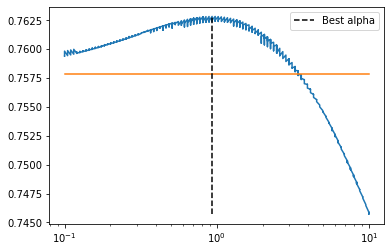

In [53]:
import matplotlib.pyplot as plt
ax = plt.gca()
ax.plot(cv_res.param_alpha, cv_res.mean_test_score,
        [10**min_alpha_log, 10**max_alpha_log], [baseline_err, baseline_err])
ax.set_xscale('log')
ax.vlines(
    best_params["alpha"],
    cv_res.mean_test_score.min(),
    cv_res.mean_test_score.max(),
    color="black",
    linestyle="--",
    label="Best alpha",
)
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


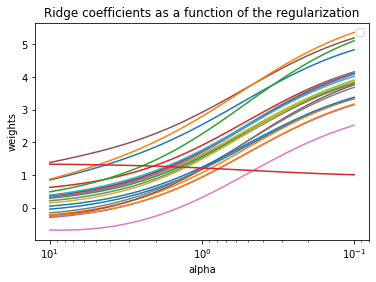

In [54]:
# cf. https://scikit-learn.org/stable/auto_examples/linear_model/plot_ridge_path.html

import warnings
with warnings.catch_warnings():
    alphas = np.logspace(min_alpha_log, max_alpha_log, n_alphas)

    coefs = []
    for a in alphas:
        ridge = linear_model.Ridge(alpha=a, fit_intercept=False)
        ridge.fit(X, y)
        coefs.append(ridge.coef_[0])

    #coefs = np.vstack(coefs)
    #flat_coefs = np.ravel(coefs)
    #display(coefs)


    ax = plt.gca()
    ax.plot(alphas, coefs)
    """ax.vlines(
        best_params["alpha"],
        #flat_coefs.min(),
        #flat_coefs.max(),
        color="black",
        linestyle="--",
        label="Best alpha",
    )"""

    ax.set_xscale("log")
    ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
    plt.xlabel("alpha")
    plt.ylabel("weights")
    plt.title("Ridge coefficients as a function of the regularization")
    plt.axis("tight")
    plt.legend()

    plt.show()

In [55]:
print_subtitle('Cross validated results :')  # TODO : mieux vaut un graphique + une sauvegarde
display(cv_res.sort_values(by='rank_test_score'))


Cross validated results :


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_random_state,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
336,0.003001,0.000004,0.002199,0.000400,0.932603,42,auto,"{'alpha': 0.9326033468832199, 'random_state': ...",0.737032,0.740057,0.763439,0.806297,0.767157,0.762796,0.024870,1
337,0.004200,0.000401,0.002601,0.000492,0.932603,42,svd,"{'alpha': 0.9326033468832199, 'random_state': ...",0.737032,0.740057,0.763439,0.806297,0.767157,0.762796,0.024870,1
341,0.002601,0.000491,0.002001,0.000895,0.932603,42,cholesky,"{'alpha': 0.9326033468832199, 'random_state': ...",0.737032,0.740057,0.763439,0.806297,0.767157,0.762796,0.024870,1
348,0.002802,0.000748,0.002399,0.000491,0.97701,42,cholesky,"{'alpha': 0.9770099572992254, 'random_state': ...",0.736883,0.740908,0.763056,0.806260,0.766857,0.762793,0.024724,4
344,0.004000,0.000002,0.002601,0.000489,0.97701,42,svd,"{'alpha': 0.9770099572992254, 'random_state': ...",0.736883,0.740908,0.763056,0.806260,0.766857,0.762793,0.024724,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
693,0.002601,0.000799,0.001799,0.000747,10.0,42,auto,"{'alpha': 10.0, 'random_state': 42, 'solver': ...",0.712226,0.752189,0.724331,0.795784,0.744866,0.745879,0.028734,695
696,0.006799,0.002228,0.002000,0.000633,10.0,42,sag,"{'alpha': 10.0, 'random_state': 42, 'solver': ...",0.712221,0.752200,0.724320,0.795788,0.744855,0.745877,0.028739,697
697,0.007599,0.002414,0.001799,0.000749,10.0,42,saga,"{'alpha': 10.0, 'random_state': 42, 'solver': ...",0.712167,0.752174,0.724317,0.795782,0.744770,0.745842,0.028749,698
699,0.003600,0.001020,0.002201,0.000401,10.0,42,lsqr,"{'alpha': 10.0, 'random_state': 42, 'solver': ...",0.712299,0.752165,0.724115,0.795842,0.744613,0.745807,0.028770,699


##### Recherche en grille intégrée

In [56]:
reg = linear_model.RidgeCV(alphas=np.logspace(-5, 15, 100)) #, store_cv_values=True)
reg.fit(X_train, y_train)

print('best', bold('alpha'), ':', reg.alpha_)
print('best', bold('n-MSE score'), ':', reg.best_score_)
print(' train', bold('r2 score'), ':', reg.score(X_train, y_train))
print('  test', bold('r2 score'), ':', reg.score(X_test, y_test))
print('global', bold('r2 score'), ':', reg.score(X, y))

from seattle_commons import show_ols_scores # TODO : à renommer
show_ols_scores(reg, X, y, cv=3)

# display(reg.cv_values_)


best alpha : 0.7054802310718645
best n-MSE score : -0.284566707559062
 train r2 score : 0.7893452730986723
  test r2 score : 0.7569303722797693
global r2 score : 0.76471653403297
cv scores : [0.76607125 0.66447435 0.73363107]
mean scores : 0.7213922225403219
std scores : 0.042369991634988


## Config 14 : ventilation de la surface suivant les usages

$\{(\tilde{a}_{u_k}), \log(a):\log(e)\}$

On observe une nette amélioration de 0,106978204 par rapport à la régression OLS.

Le Ridge s'accomode particulièrement bien de la ventilation des surfaces par usage.

$R^2_{14, Ridge} \left(\{(\tilde{a}_{u_k}), \log(a):\log(e)\}\right)$ :
* $\mu = 0.7295263053369813$
* $\sigma = 0.039142736958497105$

Rappels pour comparaison :

$R^2_{14, \text{OLS}} \left(\{(\tilde{a}_{u_k}), \log(a):\log(e)\}\right)$ :
* $\mu = 0.6225481013361372$
* $\sigma = 0.08228628334571318$

$R^2_{4, \text{OLS}} \left(\{\log(a):\log(e)\}\right)$:
* $\mu = 0.5682704287868149$
* $\sigma = 0.06114819172081779$

#### Jeu de données

In [58]:
config_name = "{(_a_u_k)_k, log(a) : log(e)}"

from seattle_commons import get_ml_data_cfg
ml_data = get_ml_data_cfg(data, config_name); # display(ml_data)

#### Visualisation

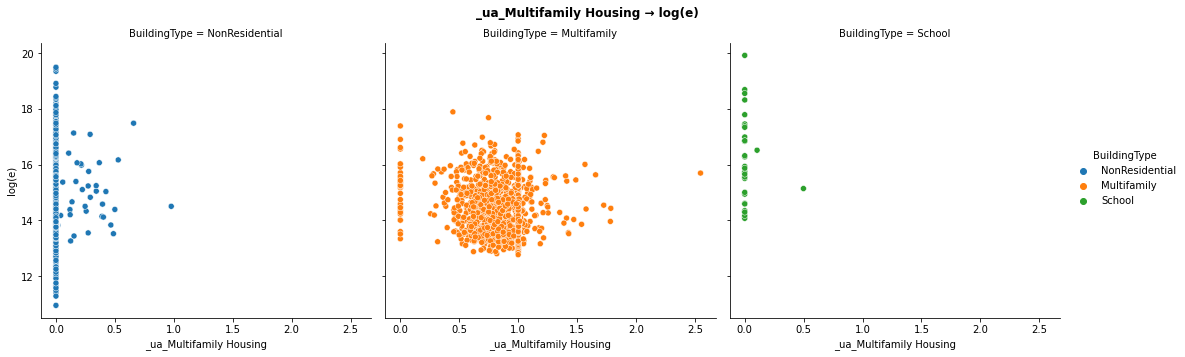

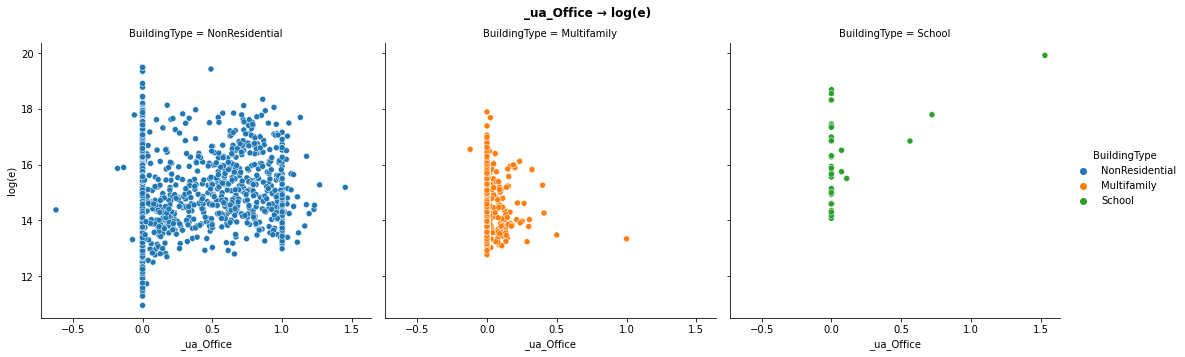

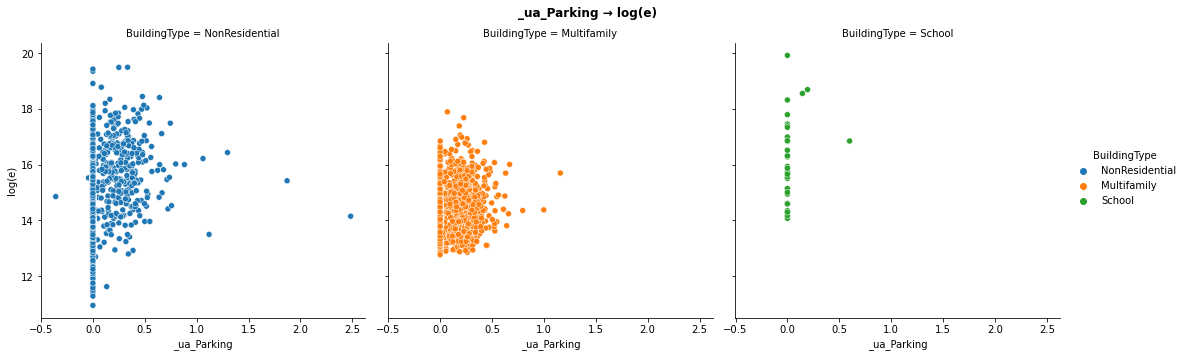

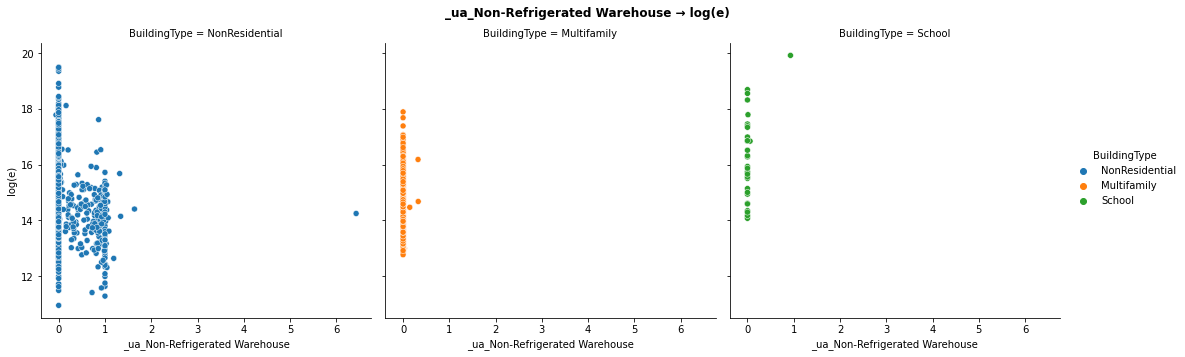

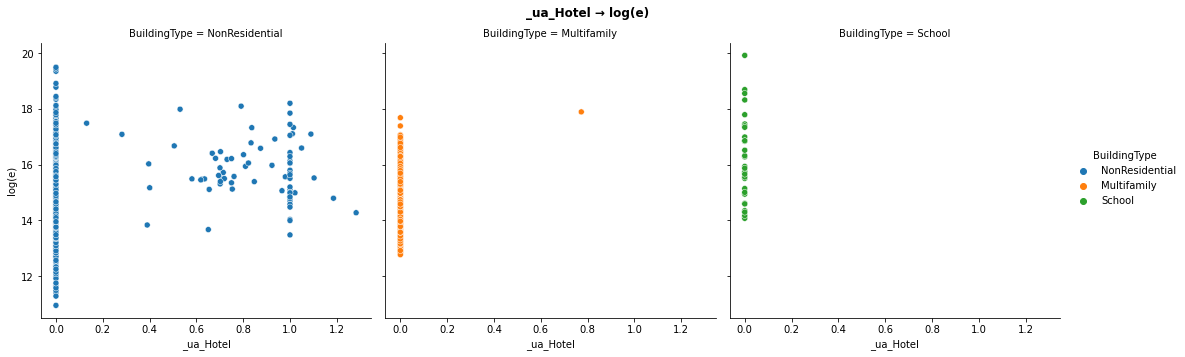

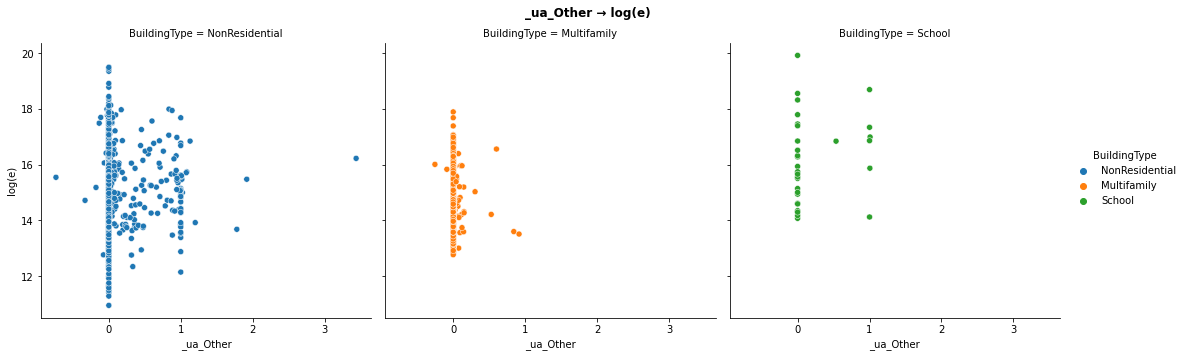

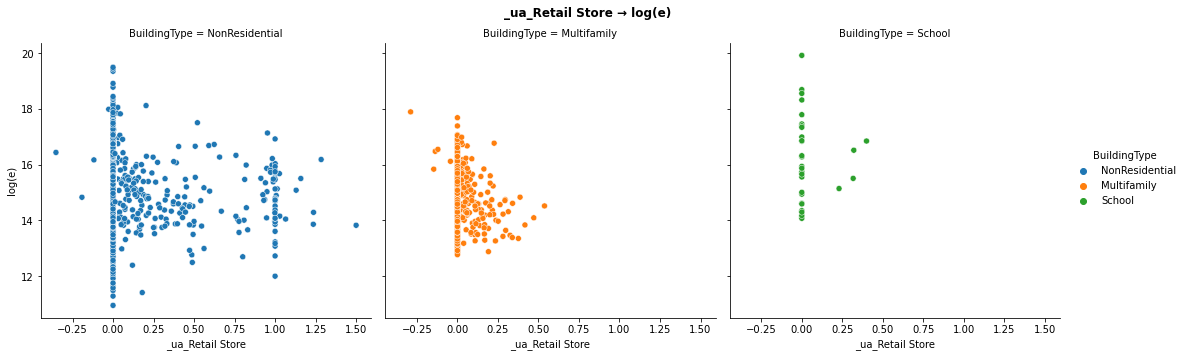

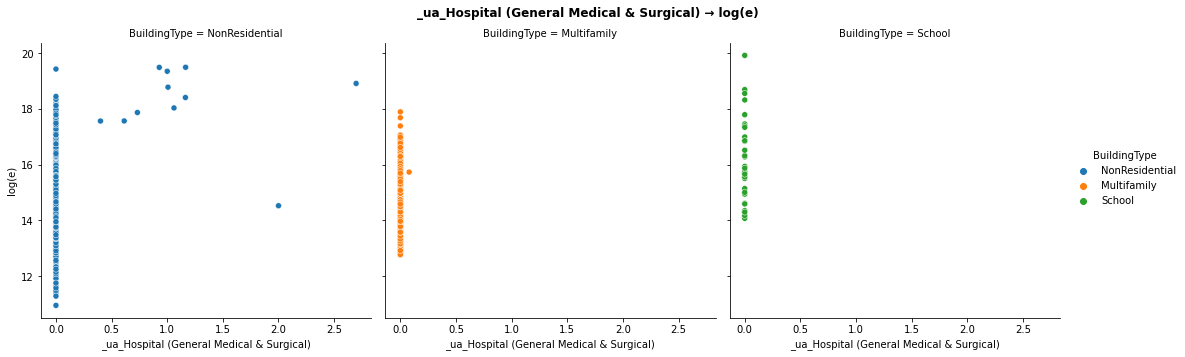

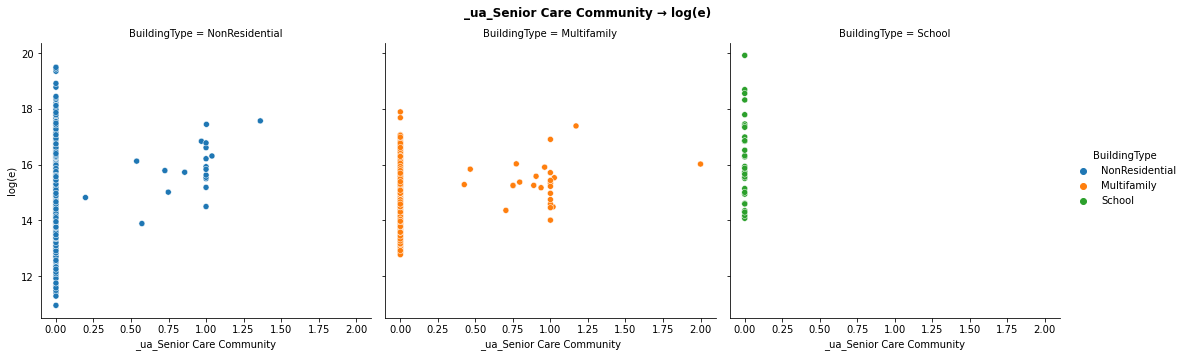

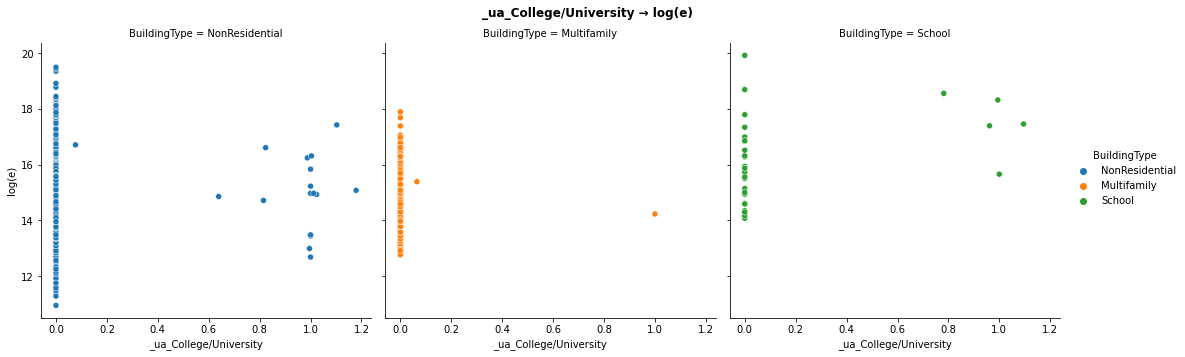

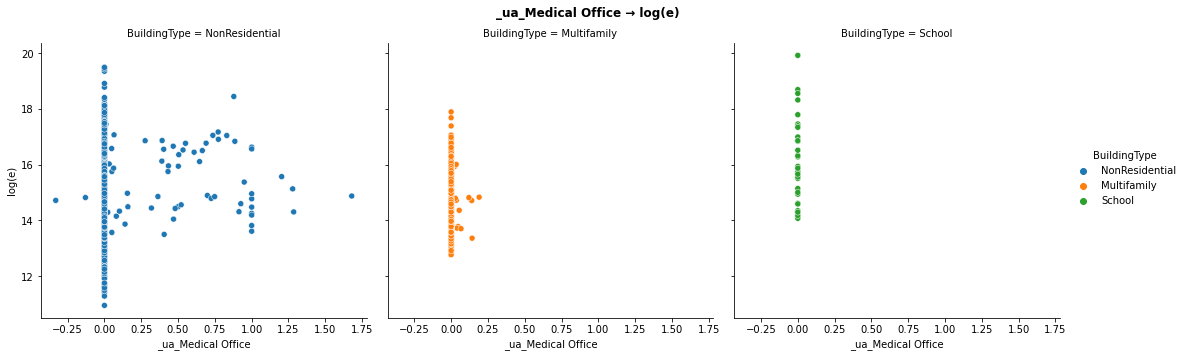

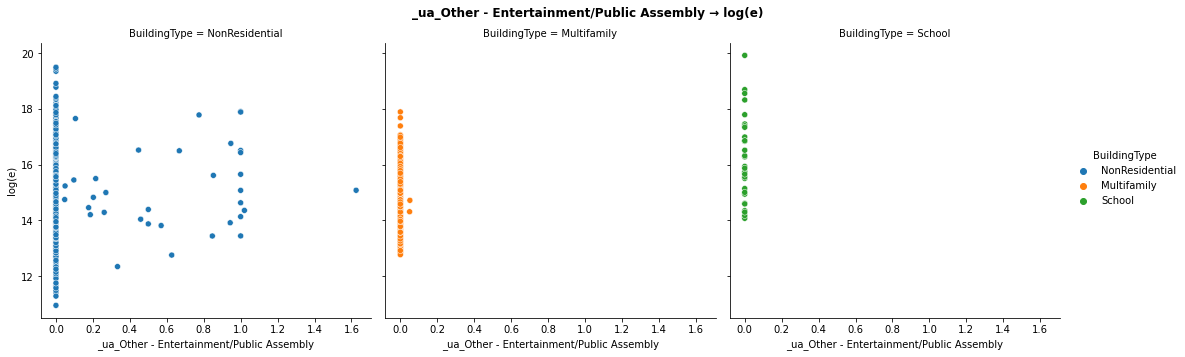

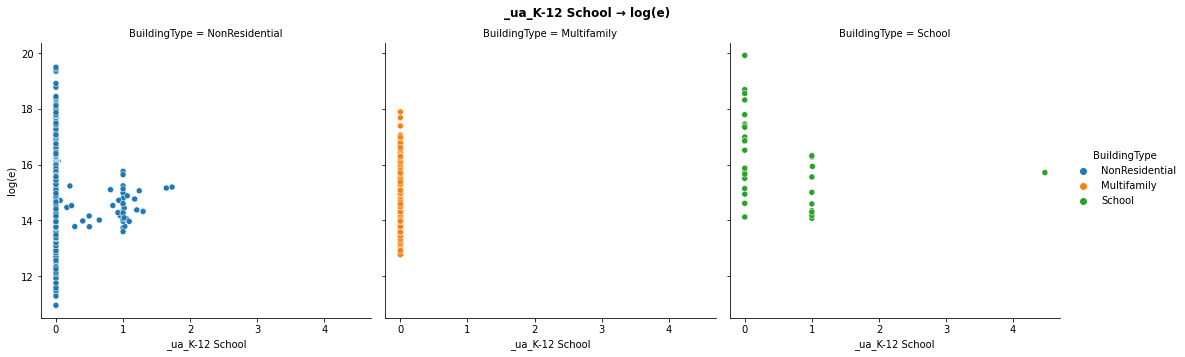

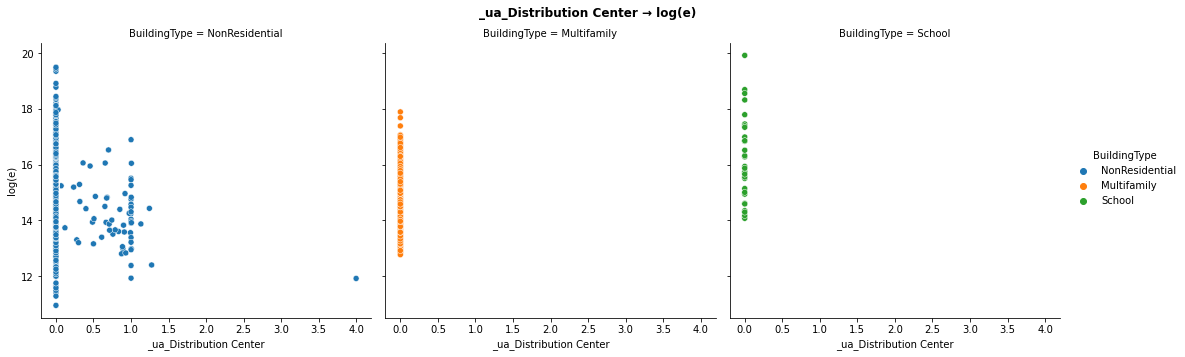

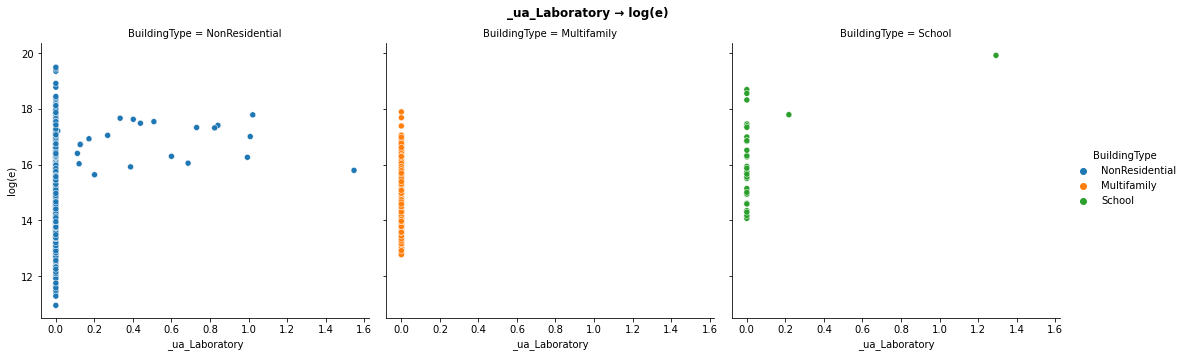

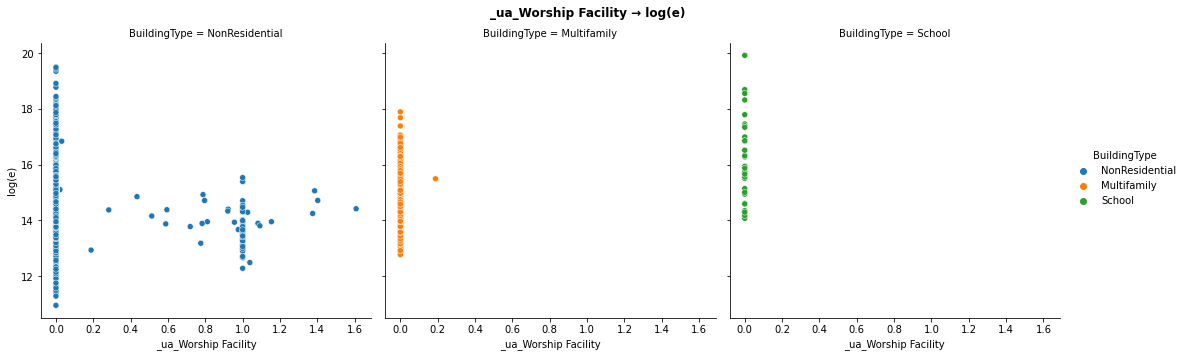

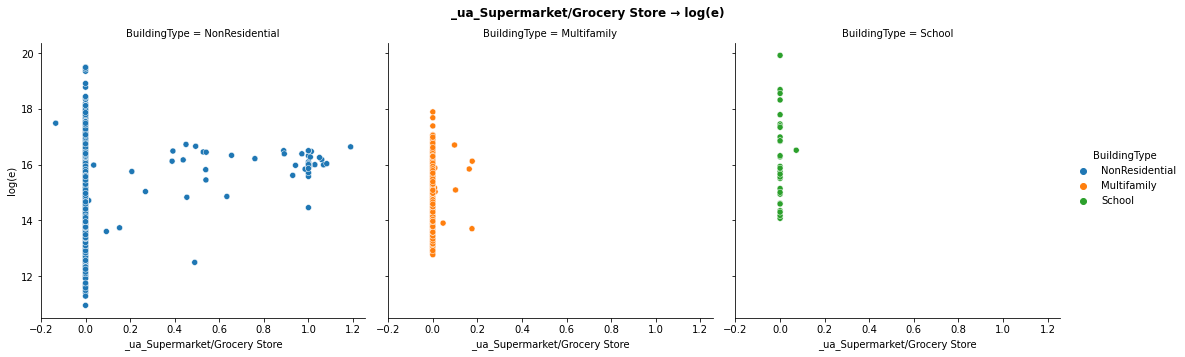

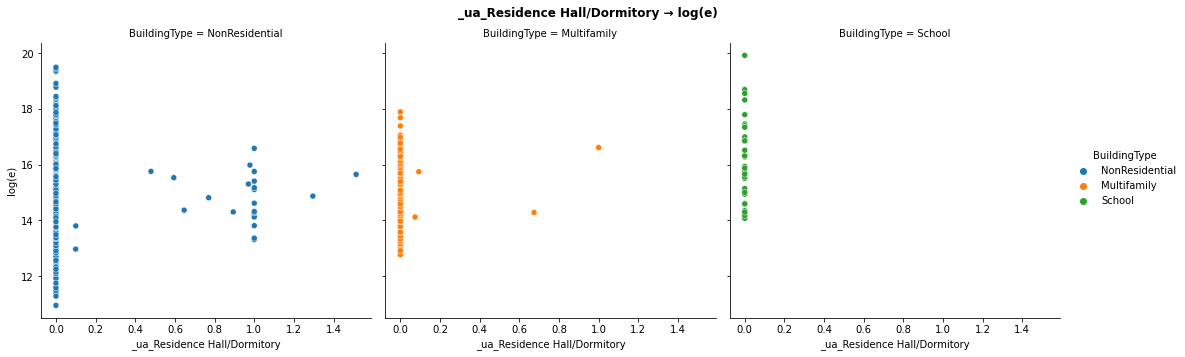

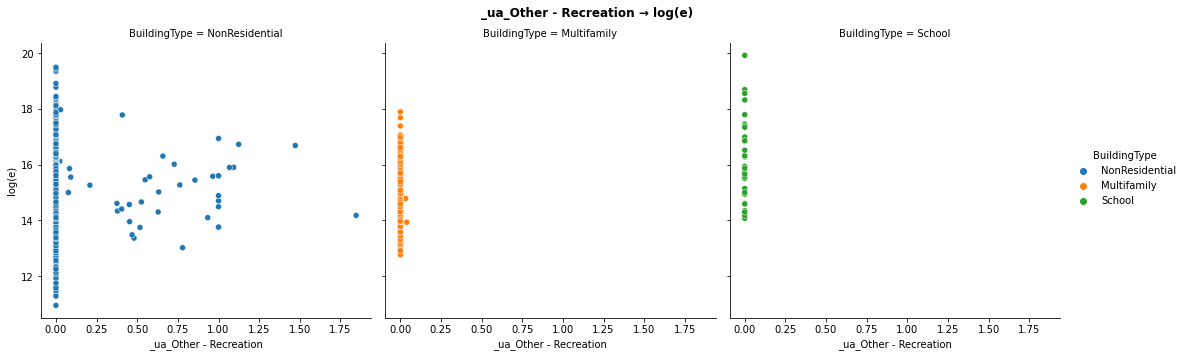

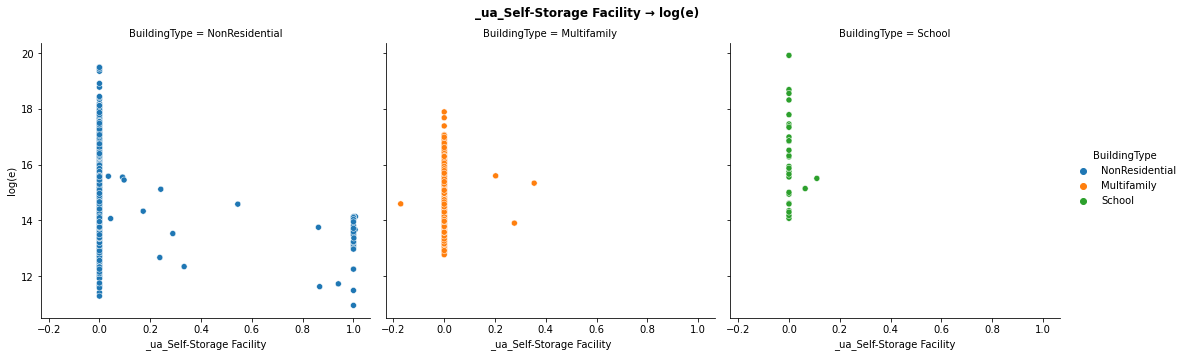

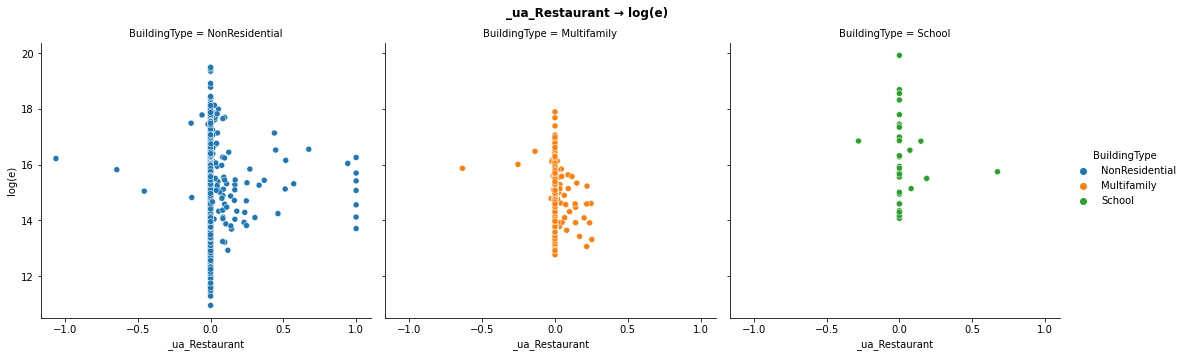

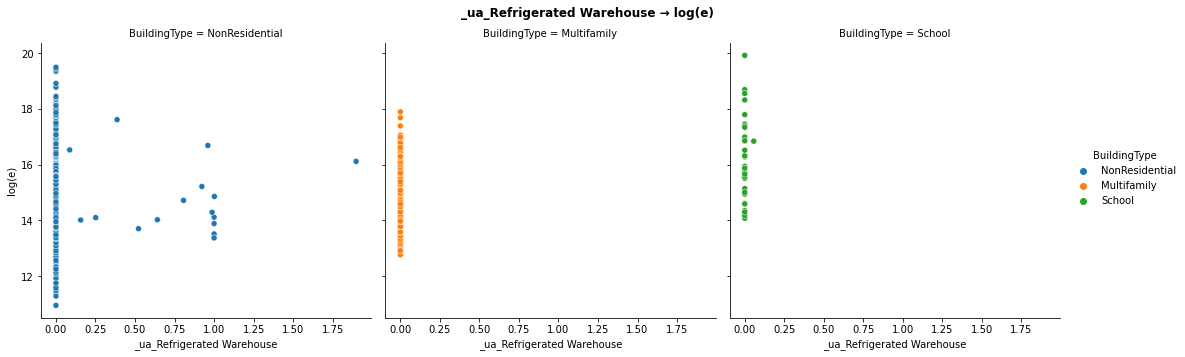

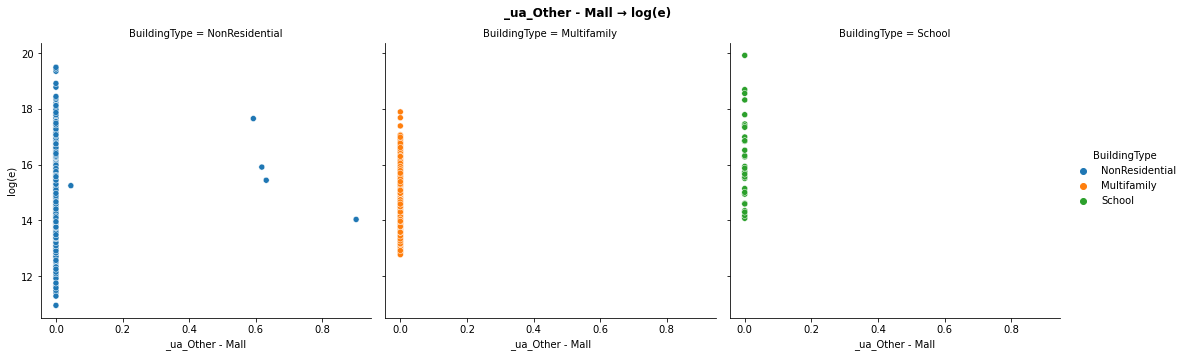

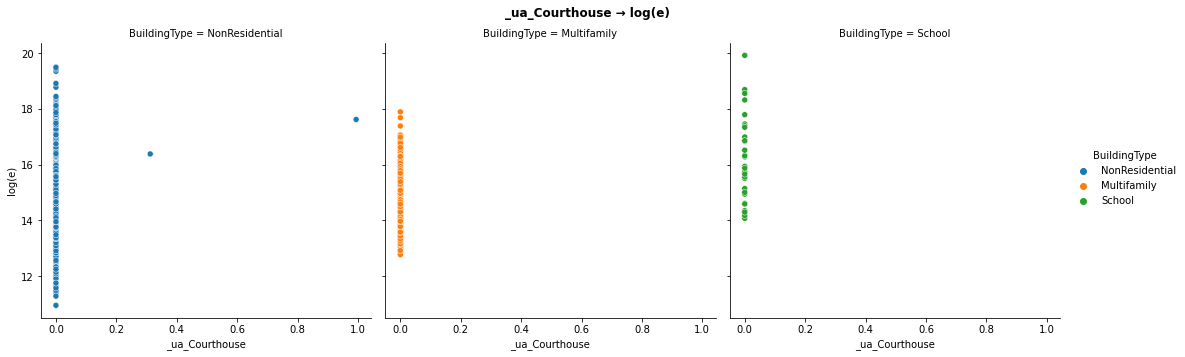

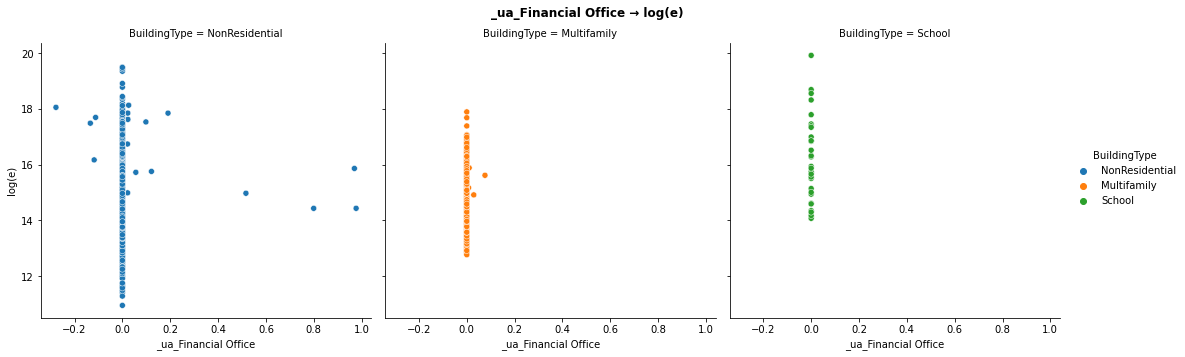

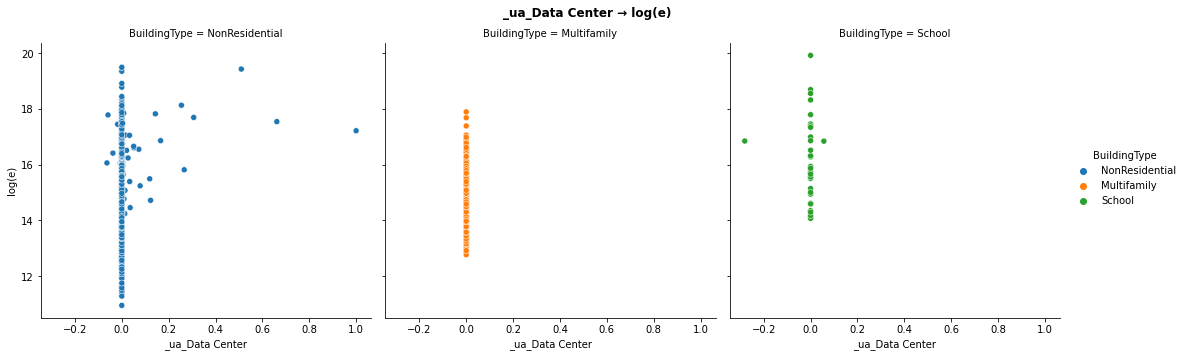

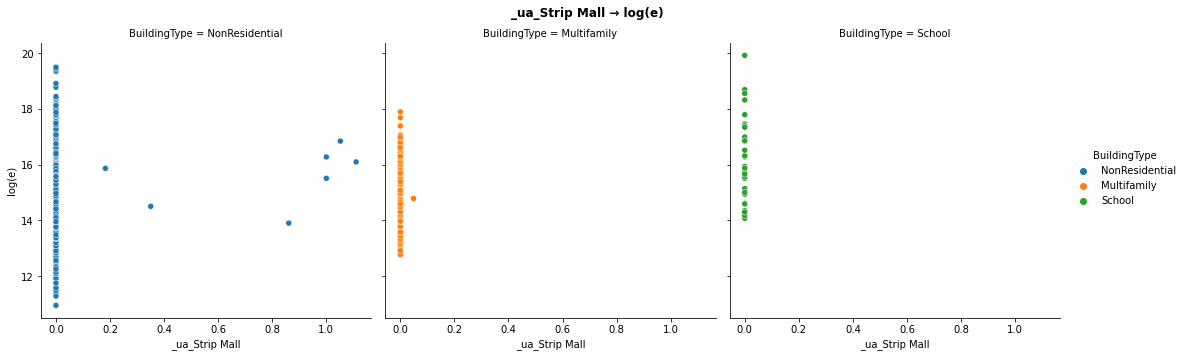

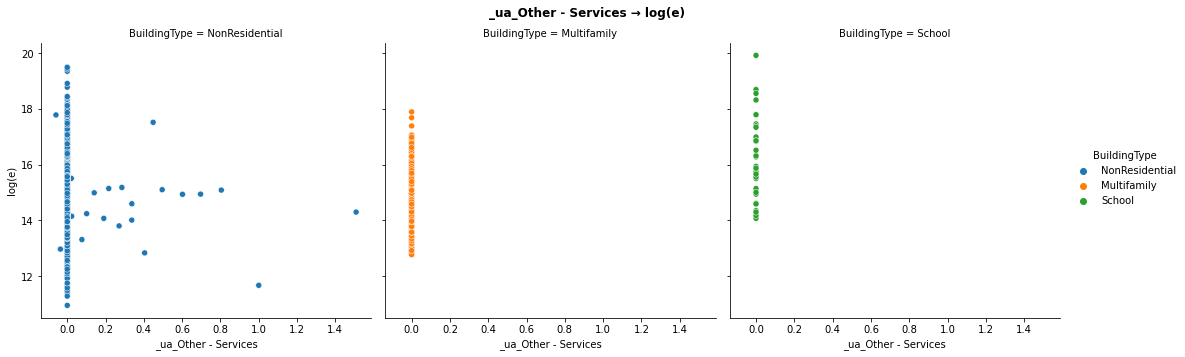

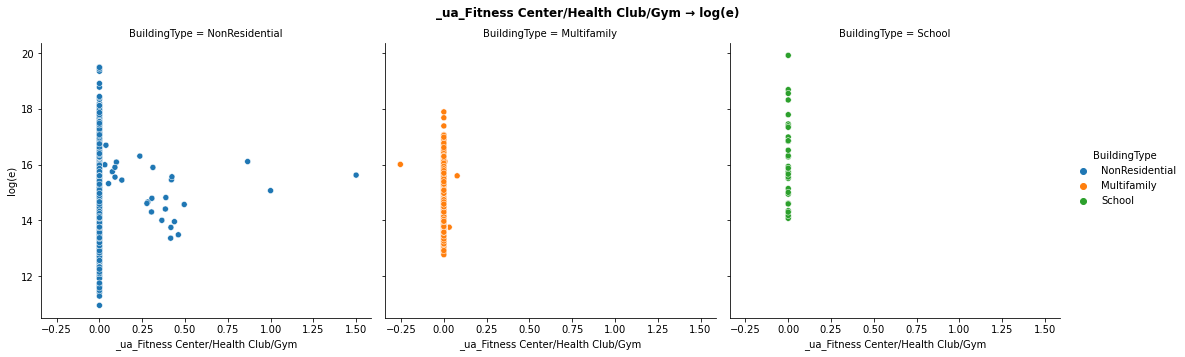

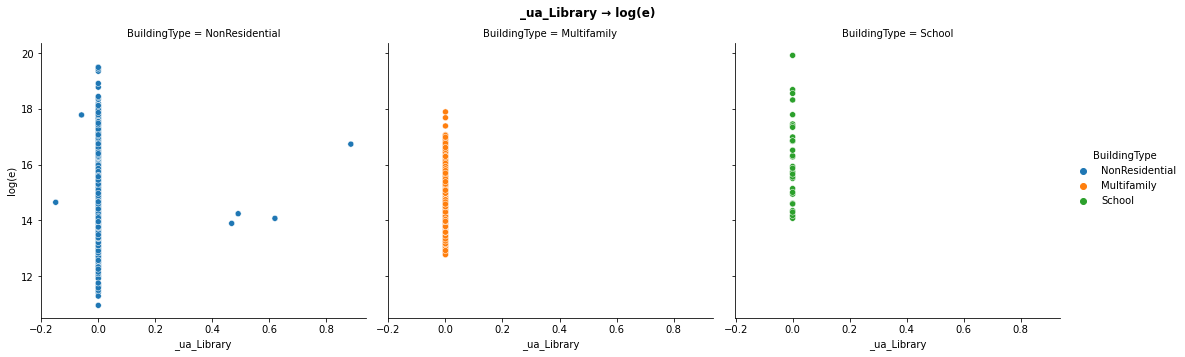

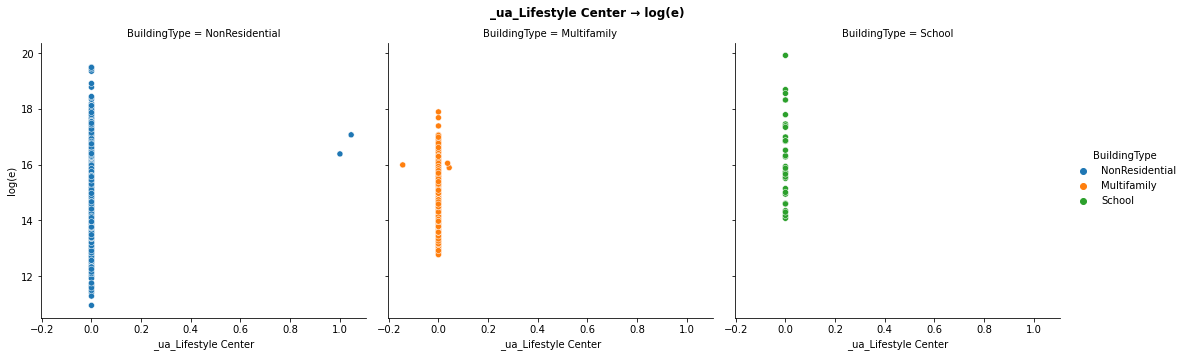

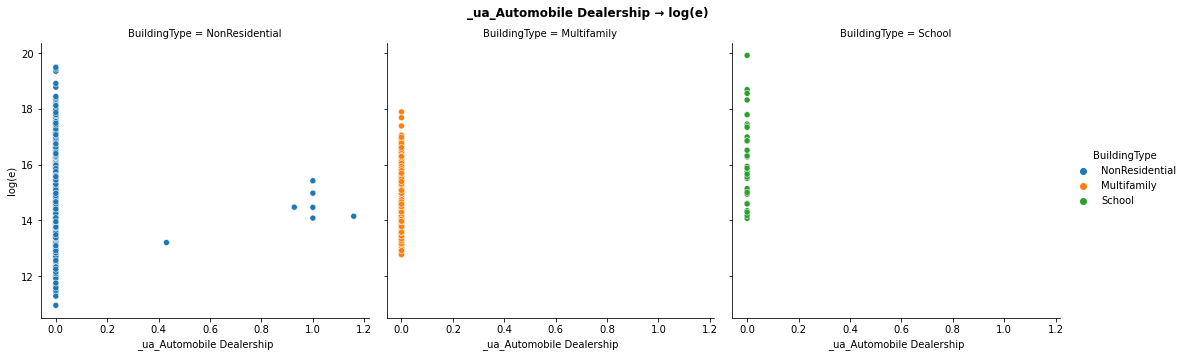

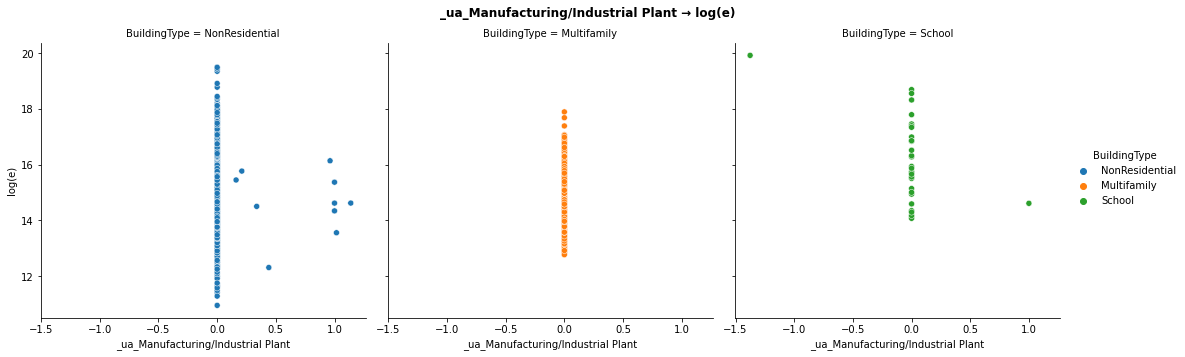

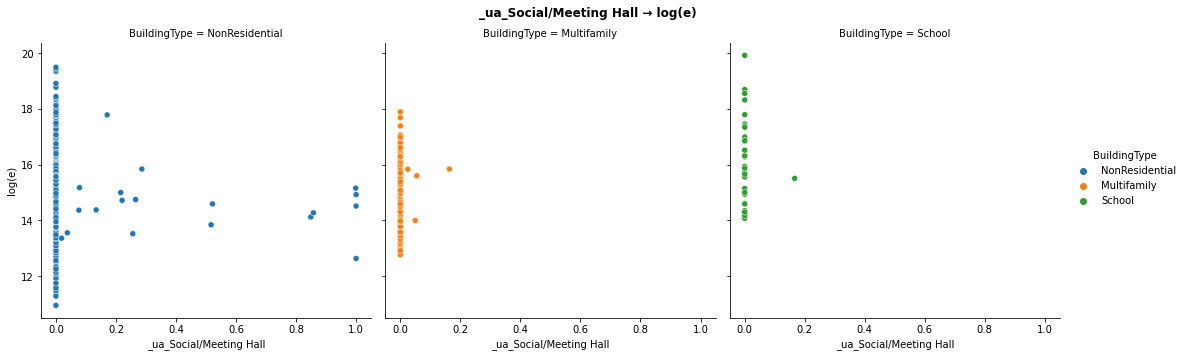

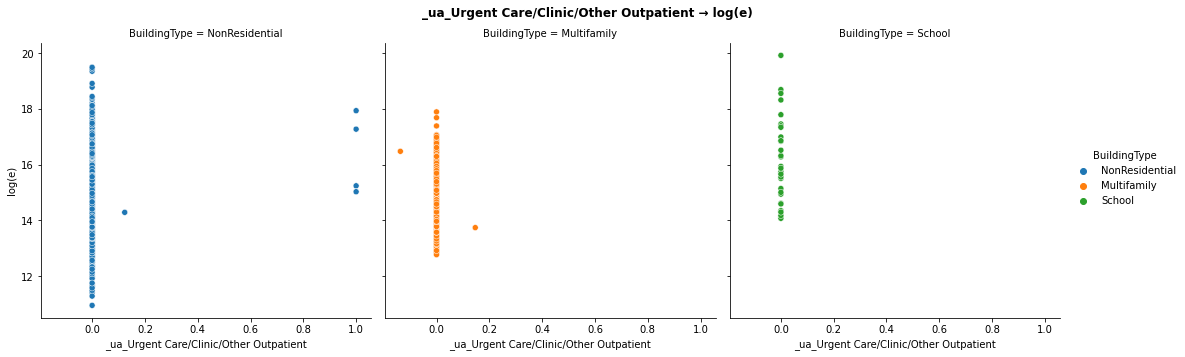

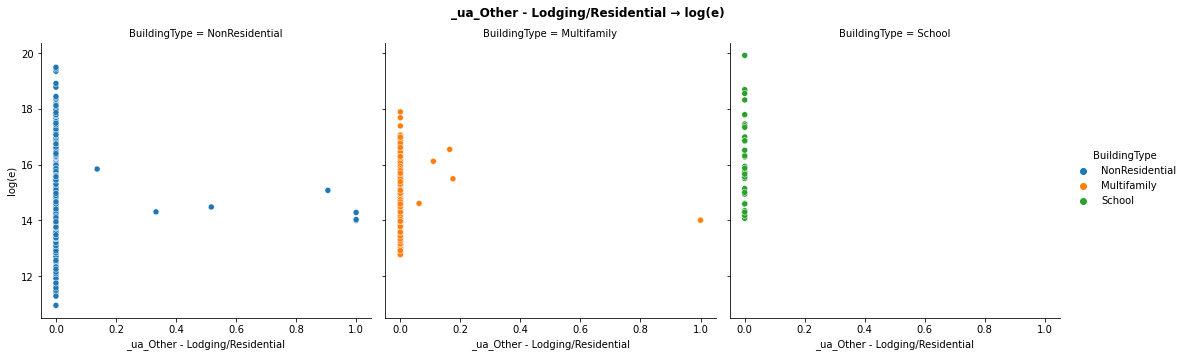

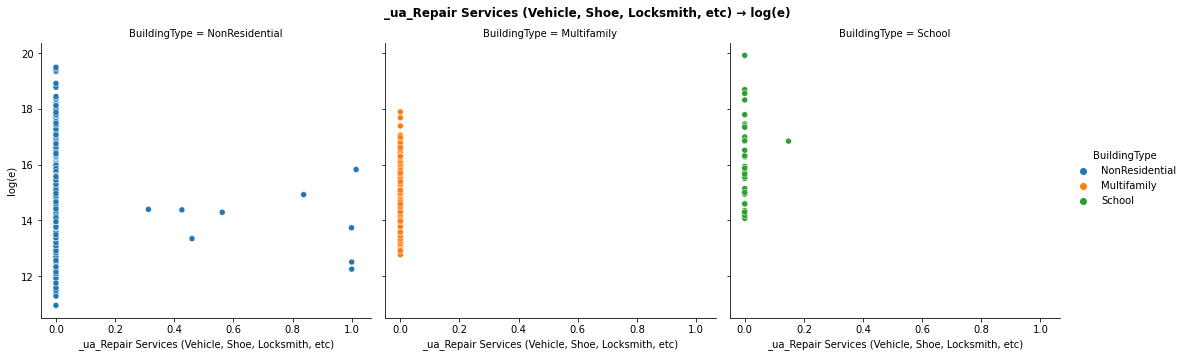

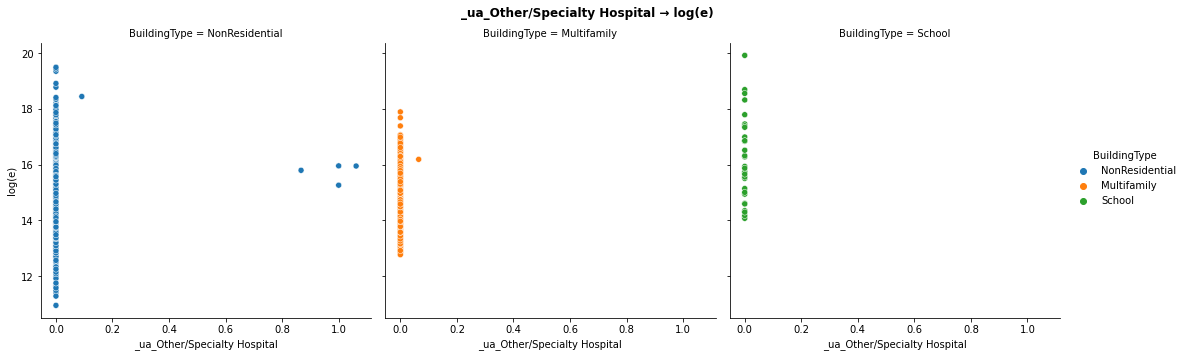

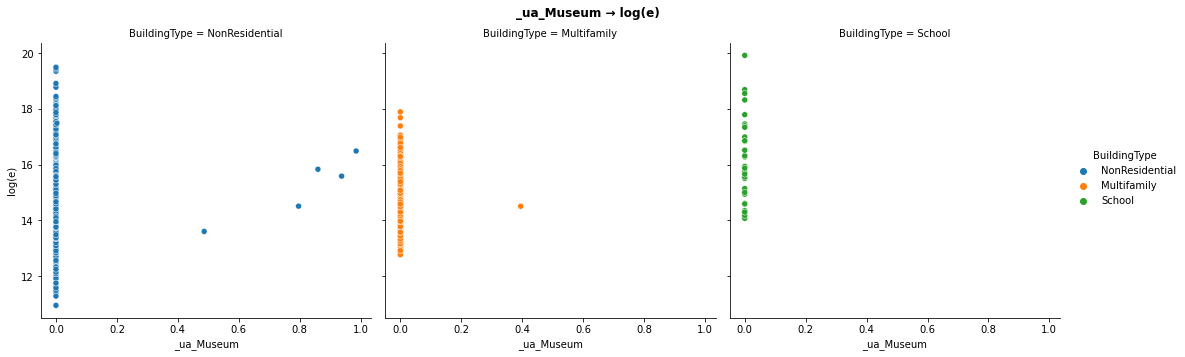

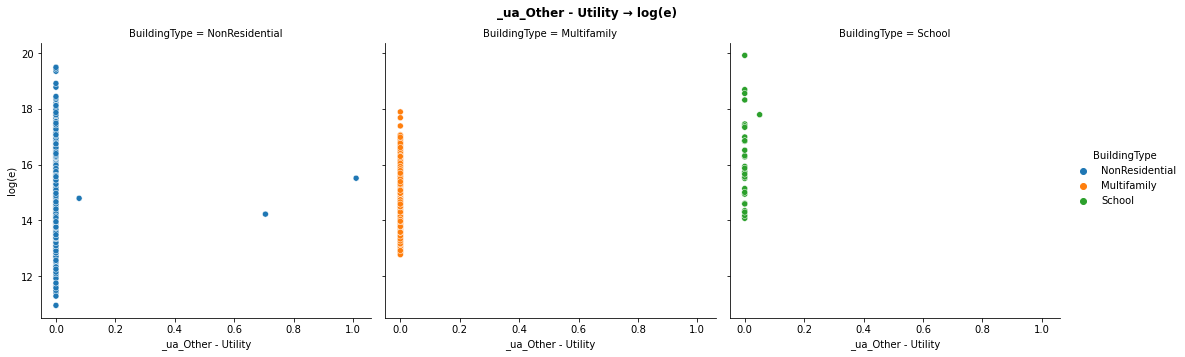

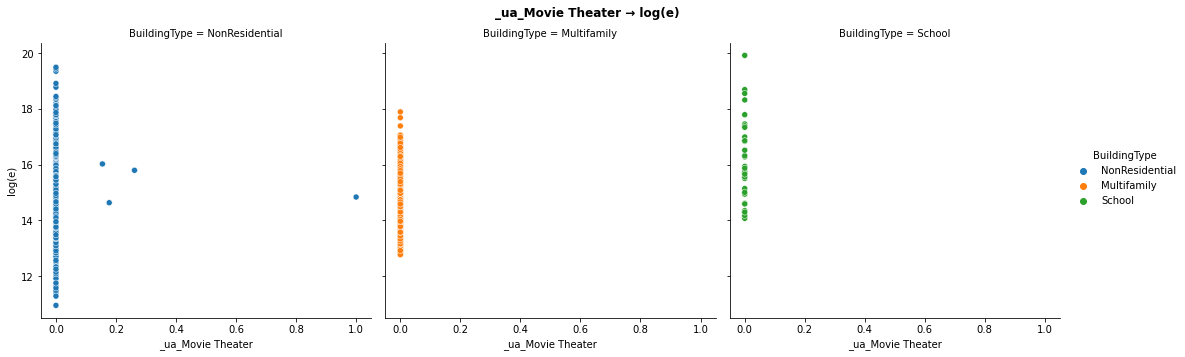

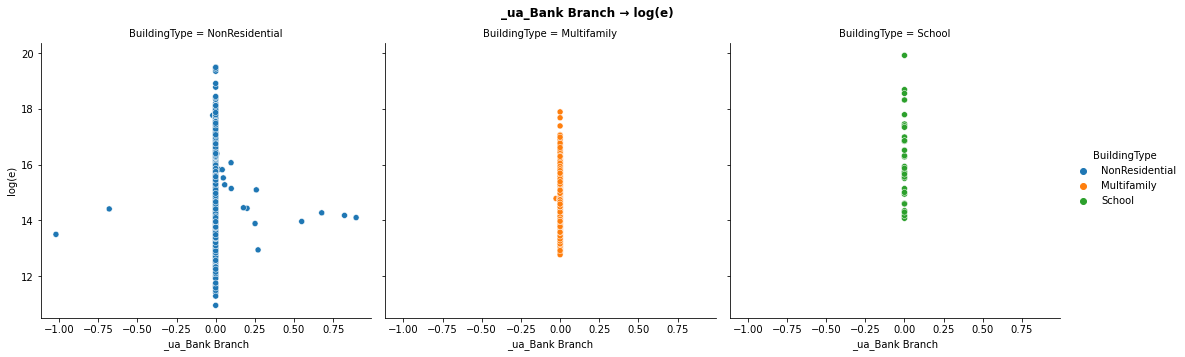

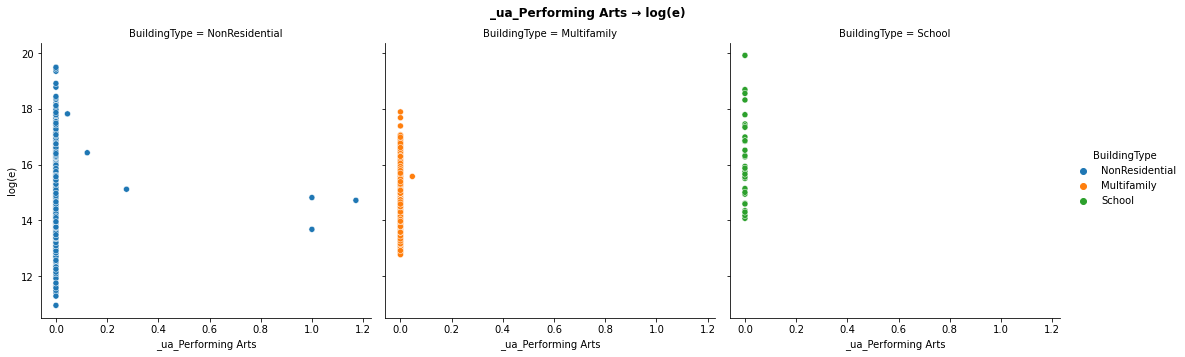

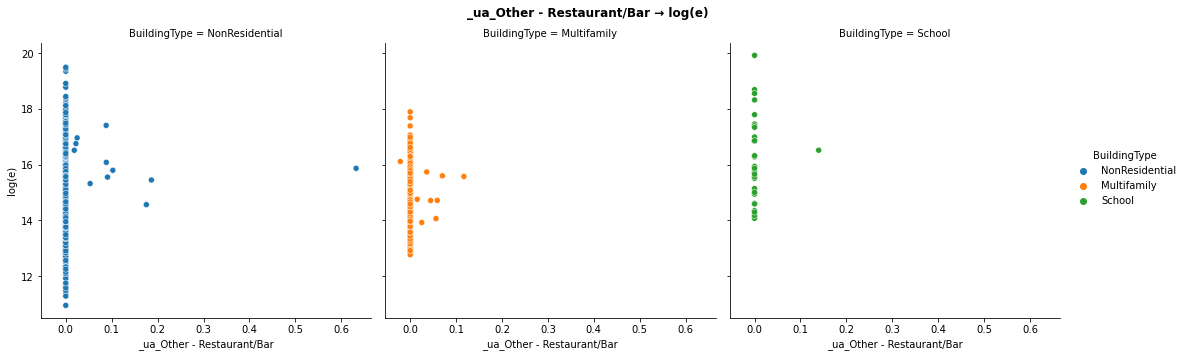

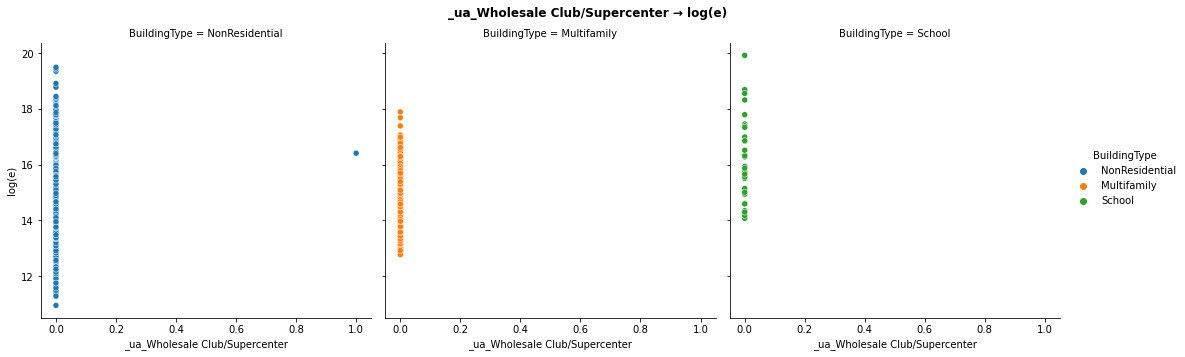

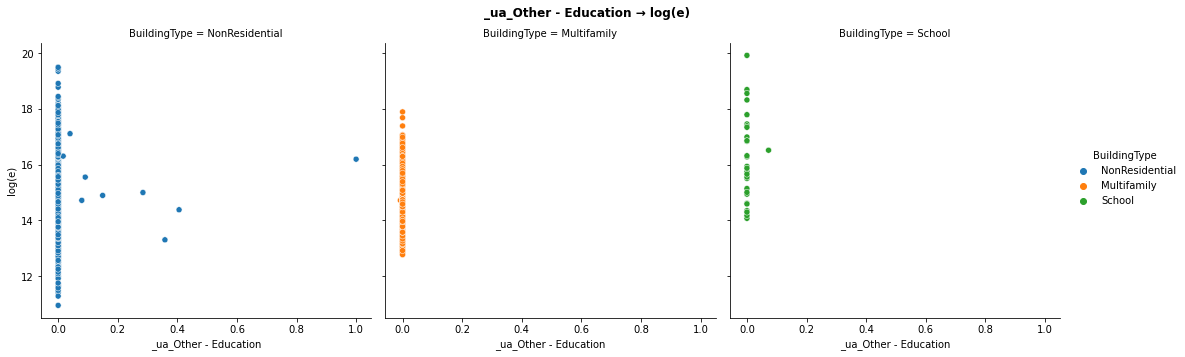

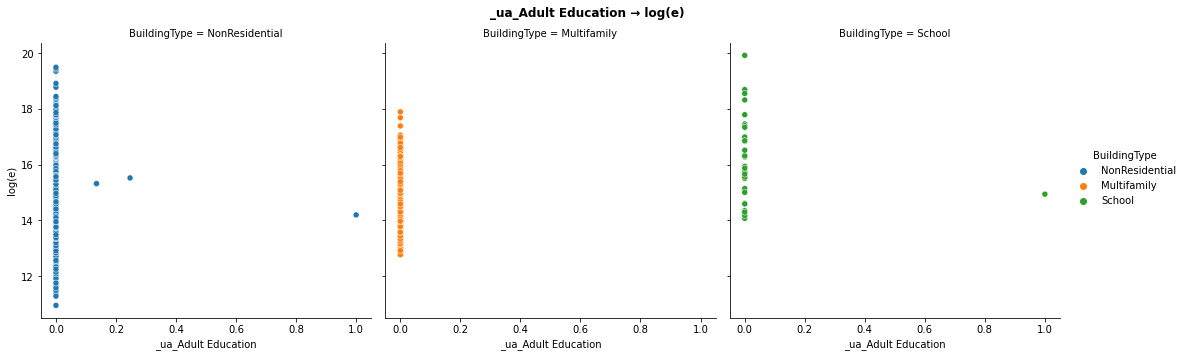

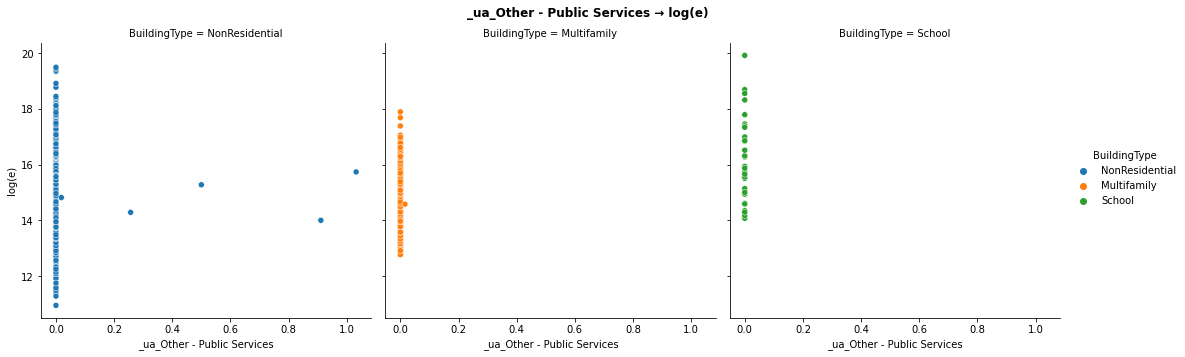

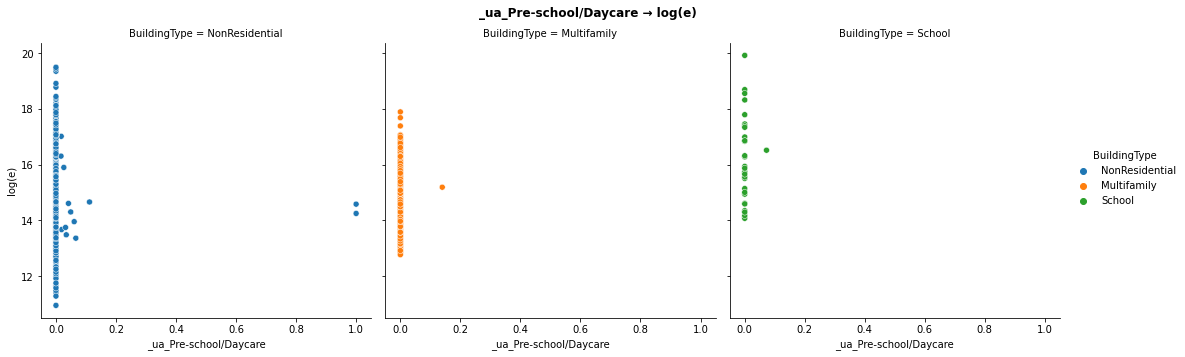

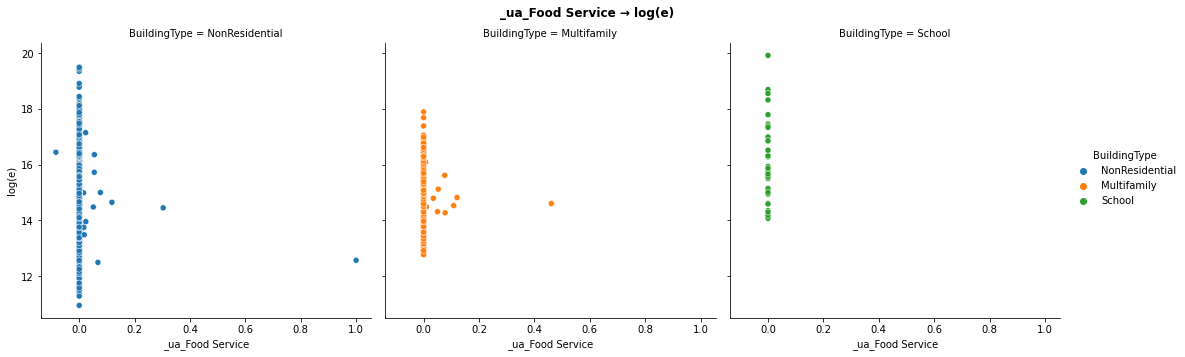

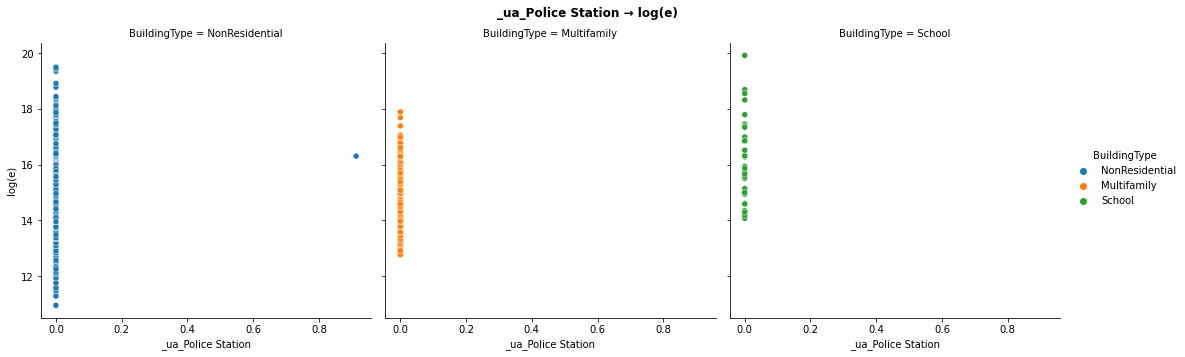

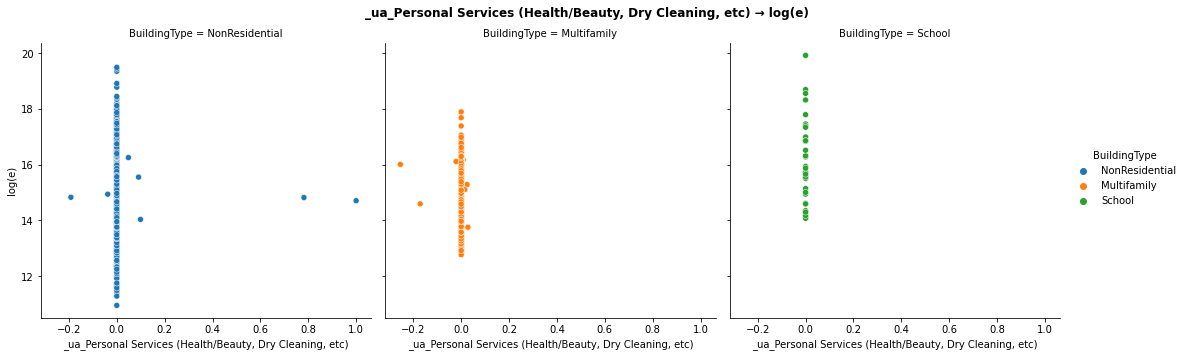

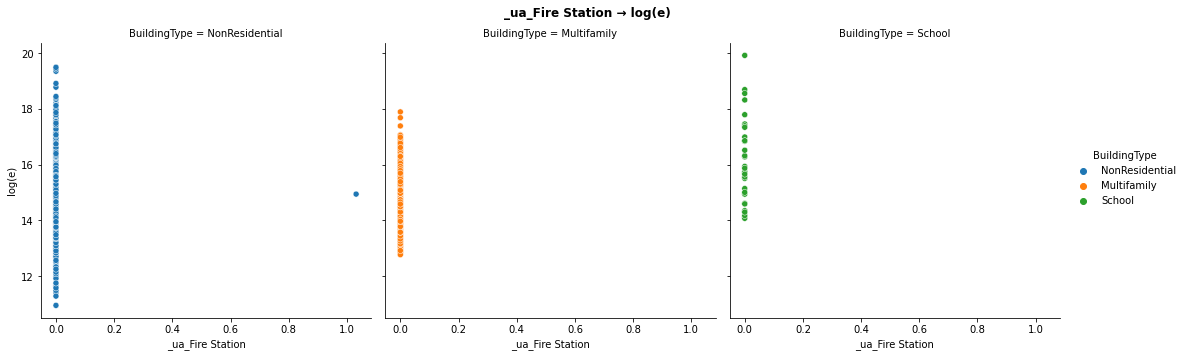

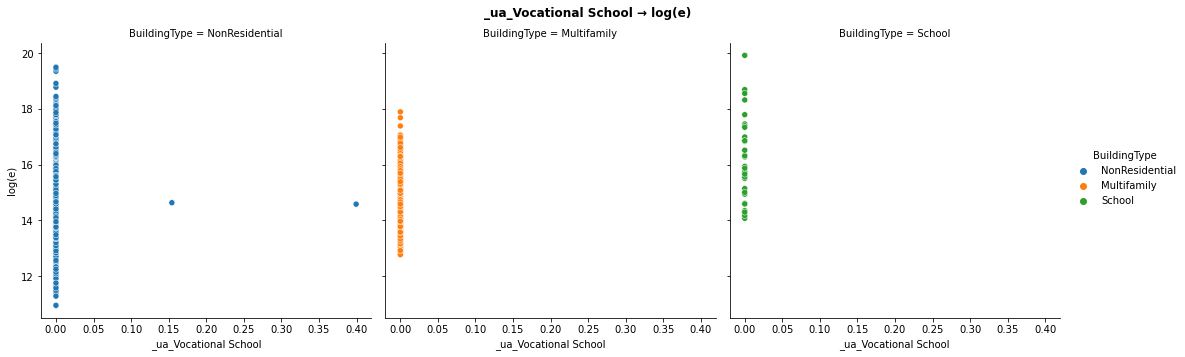

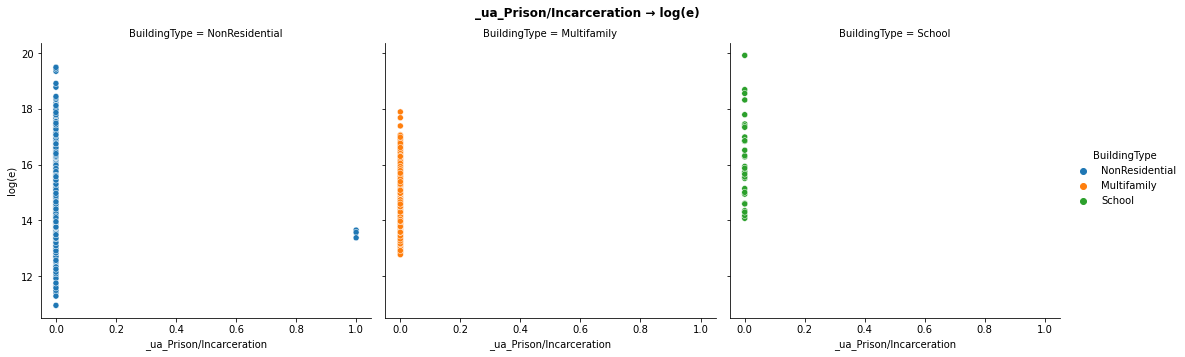

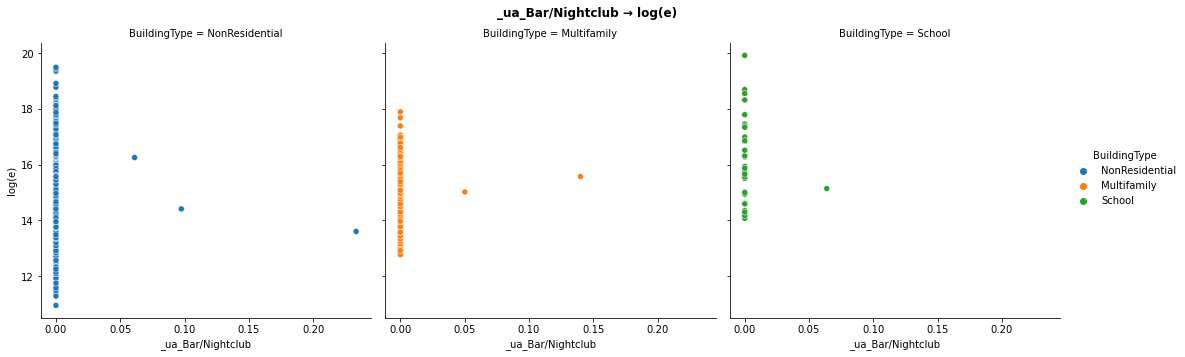

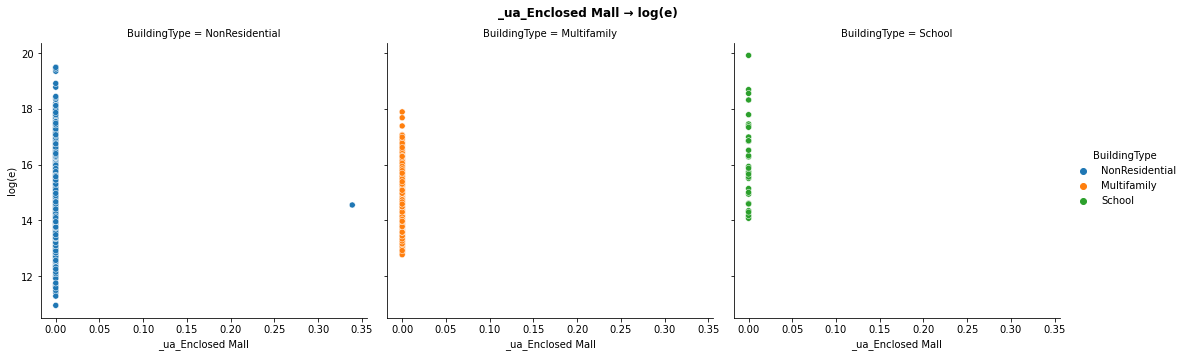

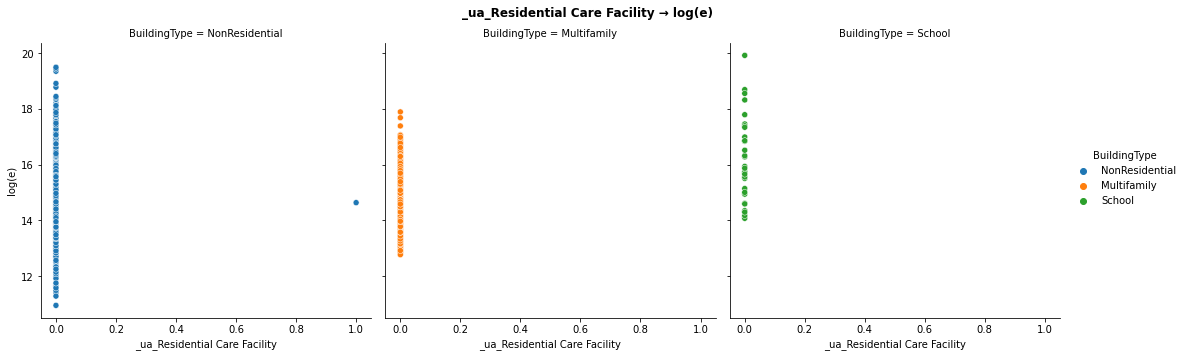

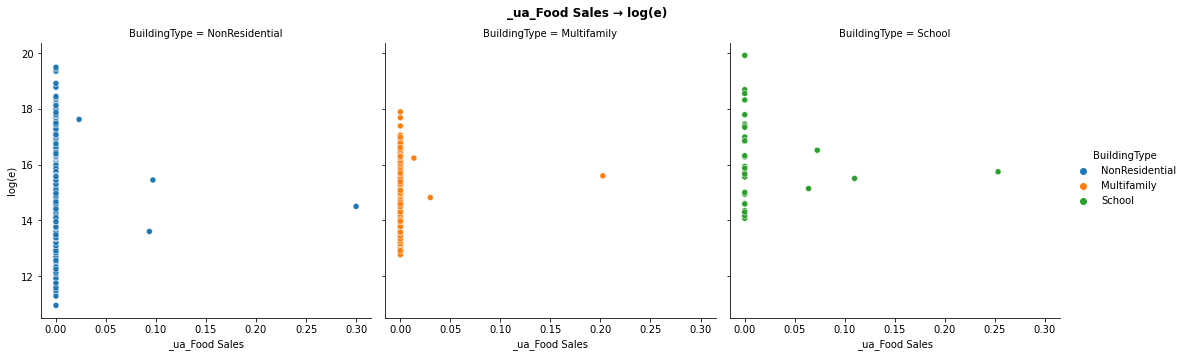

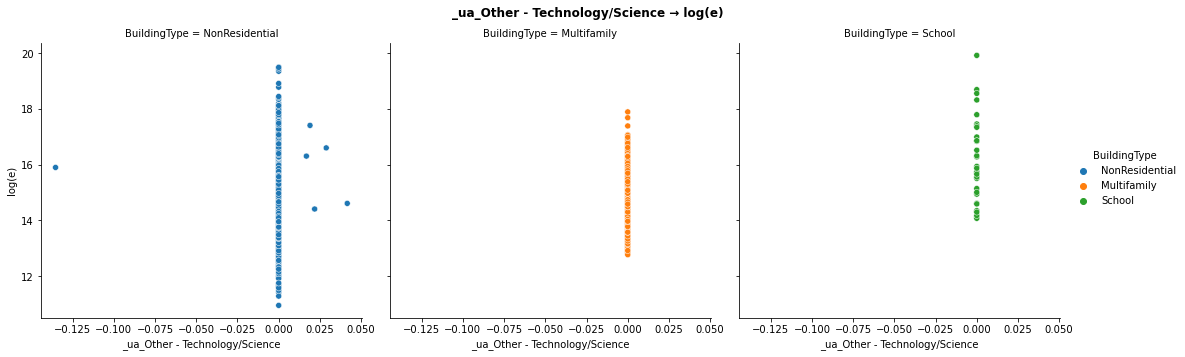

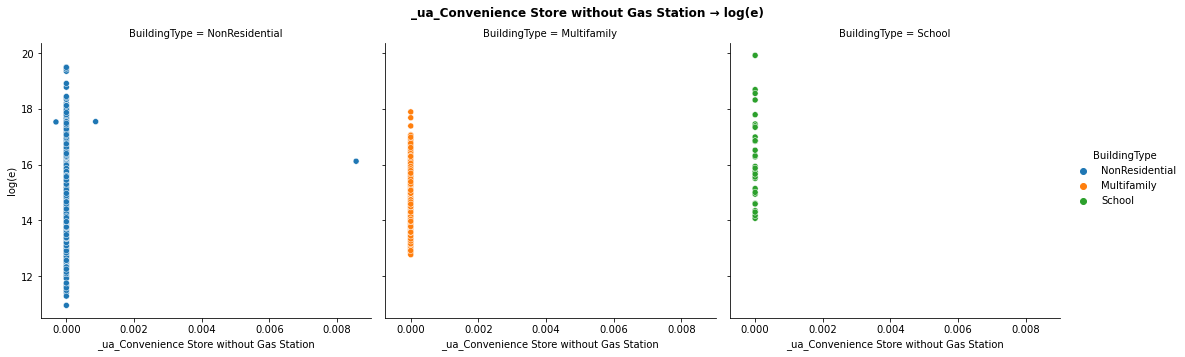

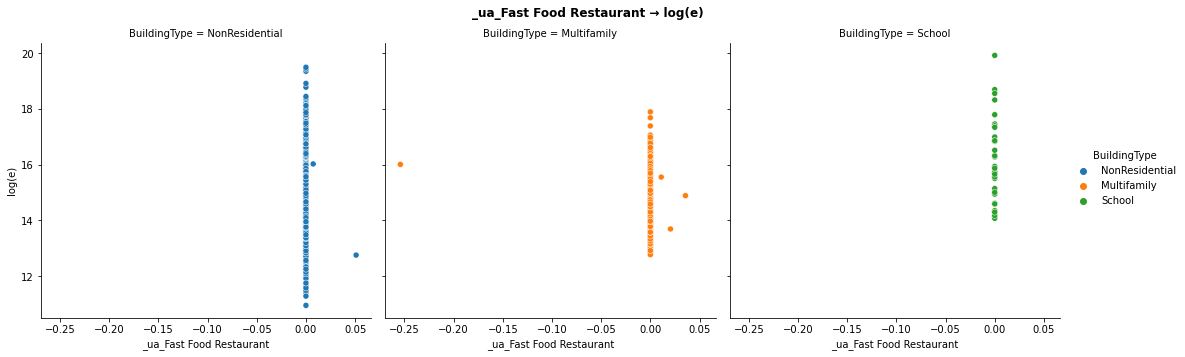

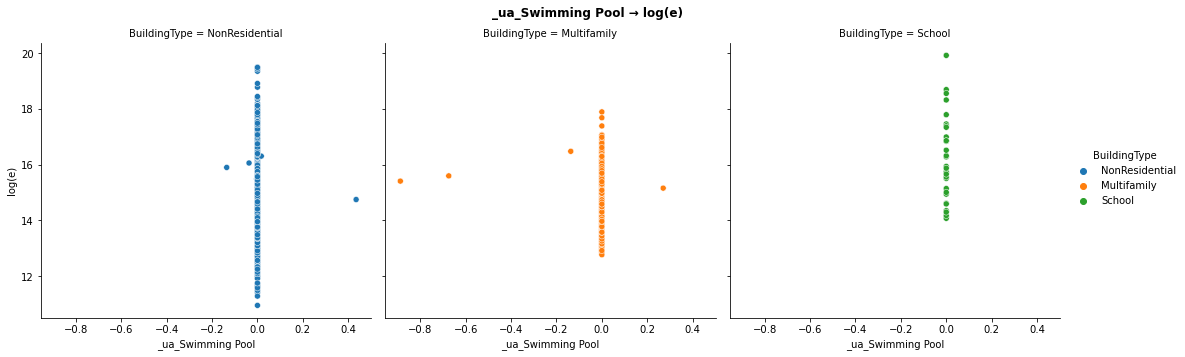

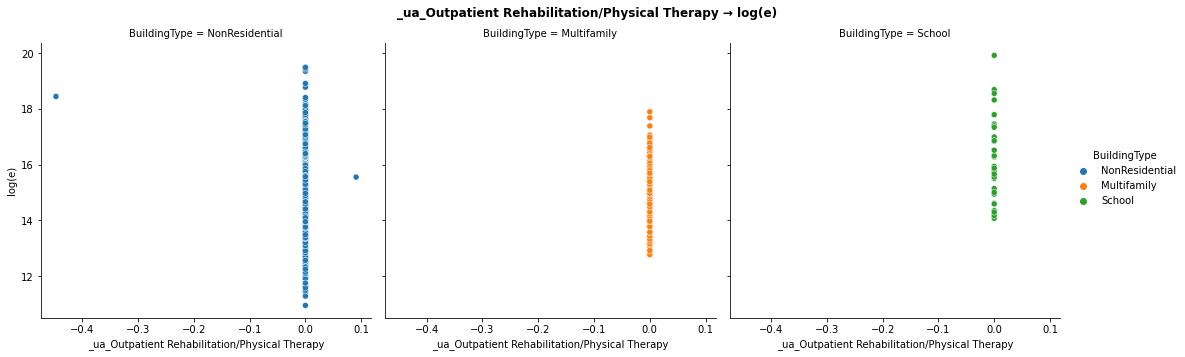

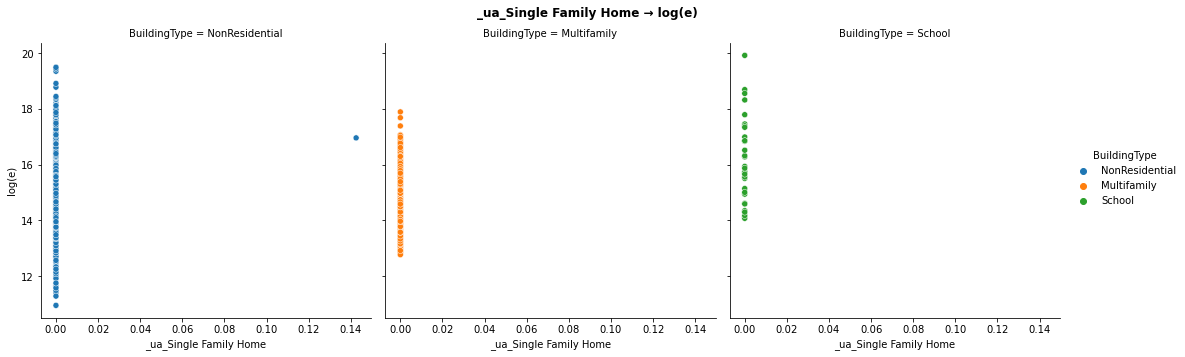

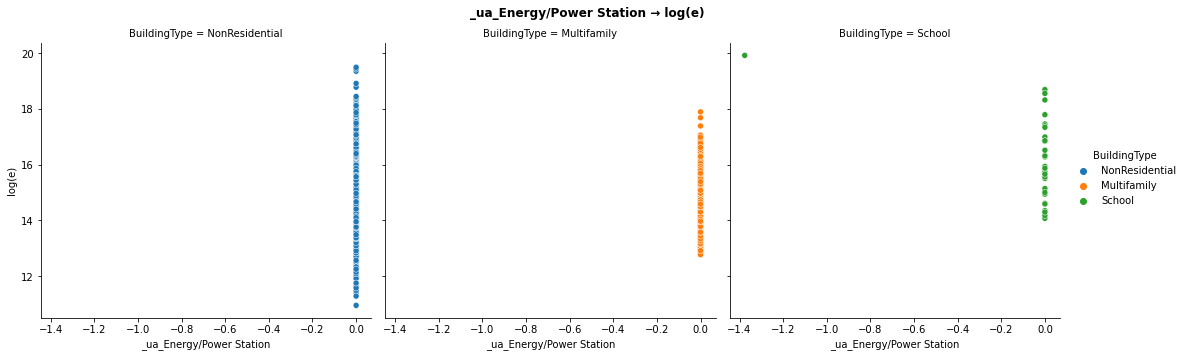

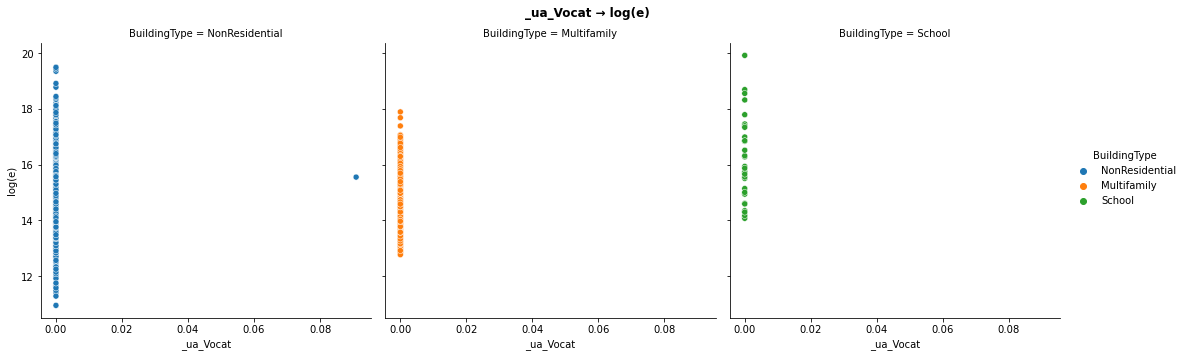

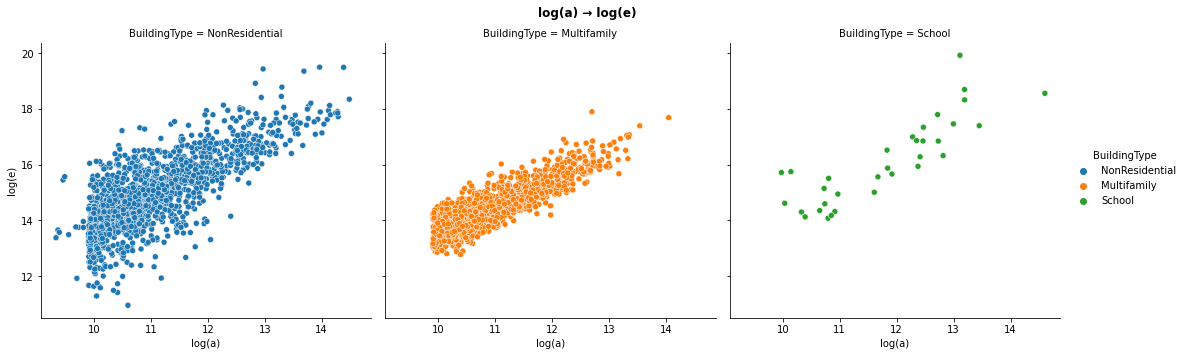

In [59]:
from seattle_commons import get_abstract_btype, plot_ml_data_all
btype = get_abstract_btype(data)
plot_ml_data_all(ml_data, btype)

#### Vérifications

In [60]:
from seattle_commons import check_data
check_data(ml_data)

✘ Negative coefficients :


,_ua_Multifamily Housing,_ua_Office,_ua_Parking,_ua_Non-Refrigerated Warehouse,_ua_Hotel,_ua_Other,_ua_Retail Store,_ua_Hospital (General Medical & Surgical),_ua_Senior Care Community,_ua_College/University,...,_ua_Other - Technology/Science,_ua_Convenience Store without Gas Station,_ua_Fast Food Restaurant,_ua_Swimming Pool,_ua_Outpatient Rehabilitation/Physical Therapy,_ua_Single Family Home,_ua_Energy/Power Station,_ua_Vocat,log(a),log(e)
id,,,,,,,,,,,,,,,,,,,,,
32,0.000000,0.000000,0.264690,0.000000,0.710101,0.000000,0.028360,0.0,0.0000,0.0,...,0.000000,0.000000,0.000000,-0.003151,0.000000,0.0,0.000000,0.0,11.974620,15.488496
43,0.000000,1.529857,0.000000,0.929094,0.000000,0.000000,0.000000,0.0,0.0000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,-1.376086,0.0,13.111980,19.921163
100,0.000000,0.827762,0.476520,0.000000,0.000000,0.047862,-0.352143,0.0,0.0000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,12.664465,16.439886
234,0.000000,0.094051,0.000000,0.841983,0.000000,0.000000,0.000000,0.0,0.0000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,10.825601,12.972641
238,0.000000,0.636102,0.130034,0.000000,0.000000,-0.063475,0.000000,0.0,0.0000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,11.420042,16.063888
247,0.000000,0.208310,0.000000,0.000000,0.000000,0.142570,0.000000,0.0,0.0000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,12.096040,16.060086
248,0.000000,0.196675,0.000000,0.696299,0.000000,-0.178359,0.000000,0.0,0.0000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,10.979172,15.183818
264,0.528618,0.000000,0.269342,0.000000,0.000000,0.000000,-0.117963,0.0,0.0000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,11.615347,16.172386
265,0.698949,0.234320,0.000000,0.000000,0.000000,0.000000,-0.043156,0.0,0.0000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,11.669476,16.122100


✔ No NA coefficient


#### Partition

In [61]:
from seattle_commons import features_target_split
X, y = features_target_split(ml_data)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

#### Entraînement

##### Recherche en grille externe

In [62]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    lr = linear_model.LinearRegression()
    lr_reg = lr.fit(X_train, y_train)
    baseline_err = cross_val_score(lr_reg, X_train, y_train, cv=5).mean()
    print(baseline_err)

0.08756861246057353


In [ ]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from pepper_commons import print_title, print_subtitle, bold
import time
from pepper_skl_commons import Dataset, get_baseline_err, search_best_params, get_best_params

Xy = X_train, X_test, y_train, y_test
model = linear_model.Ridge()
min_alpha_log = -1
max_alpha_log = 1
n_alphas = 100

param_grid = {
    'alpha': np.logspace(min_alpha_log, max_alpha_log, n_alphas),
    'solver': ['auto', 'svd', 'sparse_cg', 'sag', 'saga', 'cholesky', 'lsqr'], #, 'lbfgs'
    'random_state': [42]
}

best_estimator = best_params = best_score = best_index = scorer = cv_res = None
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    (
        best_estimator,
        best_params,
        best_score,
        best_index,
        scorer,
        cv_res
    ) = get_best_params(Xy, model, param_grid, baseline_err, cv=5, verbose=False)

In [65]:
import warnings
with warnings.catch_warnings():
    print('best', bold('estimator'), ':', best_estimator)
    print('best', bold('params'), ':', best_params)
    print('best', bold('score'), ':', best_score)
    print('best', bold('index'), ':', best_index)
    print(bold('scorer'), ':', scorer)

    print(' train', bold('score'), ':', best_estimator.score(X_train, y_train))
    print('  test', bold('score'), ':', best_estimator.score(X_test, y_test))
    print('global', bold('score'), ':', best_estimator.score(X, y))

    print('best', bold('estimator'), 'intercept :', best_estimator.intercept_)
    print('best', bold('estimator'), '    coefs :', best_estimator.coef_)

    from seattle_commons import show_ols_scores # TODO : à renommer
    show_ols_scores(best_estimator, X, y, cv=3)

best estimator : Ridge(alpha=1.1768119524349985, random_state=42, solver='svd')
best params : {'alpha': 1.1768119524349985, 'random_state': 42, 'solver': 'svd'}
best score : 0.7589925976355788
best index : 372
scorer : <function _passthrough_scorer at 0x000001D792EEA790>
 train score : 0.793750592651995
  test score : 0.751961612937958
global score : 0.7619687221519005
best estimator intercept : 3.7514616688395304
best estimator     coefs : [-2.60921606e-01  2.32471917e-01 -1.00212306e-01 -4.97574764e-01
  4.27622675e-01  2.98529212e-01  1.45265210e-01  7.57482114e-01
  1.86834864e-01  1.53015618e-01  5.13583954e-01  5.33369381e-01
  1.04308841e-01 -6.75570745e-01  9.91195377e-01 -1.10231776e-01
  1.54847803e+00  7.90774940e-02  1.01128729e+00 -9.69692984e-01
  1.04369281e+00  2.39733432e-01  1.39656218e-01  2.17510097e-02
 -4.27293085e-02  9.52103768e-02  4.80923949e-02 -7.05828593e-02
  4.62850881e-01 -1.06479861e-02  3.24037532e-01  2.88945773e-01
  1.48811496e-02  1.99937653e-01  2

In [66]:
print_subtitle('Cross validated results :')  # TODO : mieux vaut un graphique + une sauvegarde
display(cv_res.sort_values(by='rank_test_score'))


Cross validated results :


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_random_state,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
372,0.006401,0.000801,0.002599,0.000801,1.176812,42,svd,"{'alpha': 1.1768119524349985, 'random_state': ...",0.723789,0.745449,0.754812,0.811405,0.759507,0.758993,0.028940,1
371,0.003599,0.000802,0.002801,0.000401,1.176812,42,auto,"{'alpha': 1.1768119524349985, 'random_state': ...",0.723789,0.745449,0.754812,0.811405,0.759507,0.758993,0.028940,2
376,0.003601,0.000490,0.002199,0.000399,1.176812,42,cholesky,"{'alpha': 1.1768119524349985, 'random_state': ...",0.723789,0.745449,0.754812,0.811405,0.759507,0.758993,0.028940,2
365,0.006201,0.000748,0.001998,0.000003,1.123324,42,svd,"{'alpha': 1.1233240329780276, 'random_state': ...",0.723705,0.745224,0.755319,0.811485,0.759187,0.758984,0.028996,4
364,0.003410,0.000500,0.002790,0.000399,1.123324,42,auto,"{'alpha': 1.1233240329780276, 'random_state': ...",0.723705,0.745224,0.755319,0.811485,0.759187,0.758984,0.028996,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12,0.003792,0.000740,0.002600,0.000489,0.104762,42,cholesky,"{'alpha': 0.10476157527896648, 'random_state':...",0.705274,0.733028,0.762736,0.797847,0.690202,0.737817,0.038920,695
8,0.005198,0.001328,0.002200,0.000401,0.104762,42,svd,"{'alpha': 0.10476157527896648, 'random_state':...",0.705274,0.733028,0.762736,0.797847,0.690202,0.737817,0.038920,697
5,0.002601,0.000476,0.002208,0.000397,0.1,42,cholesky,"{'alpha': 0.1, 'random_state': 42, 'solver': '...",0.704921,0.732728,0.762533,0.797104,0.688748,0.737207,0.039089,698
1,0.008800,0.002135,0.003800,0.000400,0.1,42,svd,"{'alpha': 0.1, 'random_state': 42, 'solver': '...",0.704921,0.732728,0.762533,0.797104,0.688748,0.737207,0.039089,698


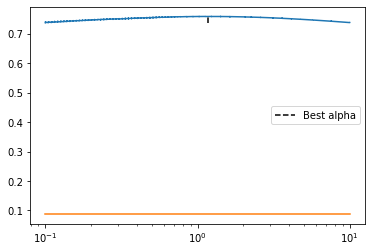

In [67]:
import matplotlib.pyplot as plt
ax = plt.gca()
ax.plot(cv_res.param_alpha, cv_res.mean_test_score,
        [10**min_alpha_log, 10**max_alpha_log], [baseline_err, baseline_err])
ax.set_xscale('log')
ax.vlines(
    best_params["alpha"],
    cv_res.mean_test_score.min(),
    cv_res.mean_test_score.max(),
    color="black",
    linestyle="--",
    label="Best alpha",
)
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


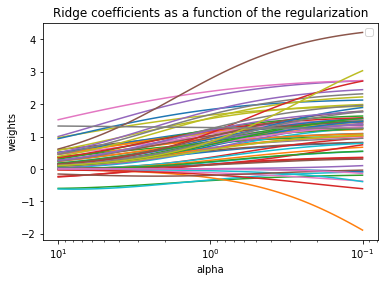

In [68]:
# cf. https://scikit-learn.org/stable/auto_examples/linear_model/plot_ridge_path.html

import warnings
with warnings.catch_warnings():
    alphas = np.logspace(min_alpha_log, max_alpha_log, n_alphas)

    coefs = []
    for a in alphas:
        ridge = linear_model.Ridge(alpha=a, fit_intercept=False)
        ridge.fit(X, y)
        coefs.append(ridge.coef_[0])

    #coefs = np.vstack(coefs)
    #flat_coefs = np.ravel(coefs)
    #display(coefs)


    ax = plt.gca()
    ax.plot(alphas, coefs)
    """ax.vlines(
        best_params["alpha"],
        #flat_coefs.min(),
        #flat_coefs.max(),
        color="black",
        linestyle="--",
        label="Best alpha",
    )"""

    ax.set_xscale("log")
    ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
    plt.xlabel("alpha")
    plt.ylabel("weights")
    plt.title("Ridge coefficients as a function of the regularization")
    plt.axis("tight")
    plt.legend()

    plt.show()

In [69]:
print_subtitle('Cross validated results :')  # TODO : mieux vaut un graphique + une sauvegarde
display(cv_res.sort_values(by='rank_test_score'))


Cross validated results :


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_random_state,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
372,0.006401,0.000801,0.002599,0.000801,1.176812,42,svd,"{'alpha': 1.1768119524349985, 'random_state': ...",0.723789,0.745449,0.754812,0.811405,0.759507,0.758993,0.028940,1
371,0.003599,0.000802,0.002801,0.000401,1.176812,42,auto,"{'alpha': 1.1768119524349985, 'random_state': ...",0.723789,0.745449,0.754812,0.811405,0.759507,0.758993,0.028940,2
376,0.003601,0.000490,0.002199,0.000399,1.176812,42,cholesky,"{'alpha': 1.1768119524349985, 'random_state': ...",0.723789,0.745449,0.754812,0.811405,0.759507,0.758993,0.028940,2
365,0.006201,0.000748,0.001998,0.000003,1.123324,42,svd,"{'alpha': 1.1233240329780276, 'random_state': ...",0.723705,0.745224,0.755319,0.811485,0.759187,0.758984,0.028996,4
364,0.003410,0.000500,0.002790,0.000399,1.123324,42,auto,"{'alpha': 1.1233240329780276, 'random_state': ...",0.723705,0.745224,0.755319,0.811485,0.759187,0.758984,0.028996,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12,0.003792,0.000740,0.002600,0.000489,0.104762,42,cholesky,"{'alpha': 0.10476157527896648, 'random_state':...",0.705274,0.733028,0.762736,0.797847,0.690202,0.737817,0.038920,695
8,0.005198,0.001328,0.002200,0.000401,0.104762,42,svd,"{'alpha': 0.10476157527896648, 'random_state':...",0.705274,0.733028,0.762736,0.797847,0.690202,0.737817,0.038920,697
5,0.002601,0.000476,0.002208,0.000397,0.1,42,cholesky,"{'alpha': 0.1, 'random_state': 42, 'solver': '...",0.704921,0.732728,0.762533,0.797104,0.688748,0.737207,0.039089,698
1,0.008800,0.002135,0.003800,0.000400,0.1,42,svd,"{'alpha': 0.1, 'random_state': 42, 'solver': '...",0.704921,0.732728,0.762533,0.797104,0.688748,0.737207,0.039089,698


##### Recherche en grille intégrée

In [70]:
reg = linear_model.RidgeCV(alphas=np.logspace(-5, 15, 100)) #, store_cv_values=True)
reg.fit(X_train, y_train)

print('best', bold('alpha'), ':', reg.alpha_)
print('best', bold('n-MSE score'), ':', reg.best_score_)
print(' train', bold('r2 score'), ':', reg.score(X_train, y_train))
print('  test', bold('r2 score'), ':', reg.score(X_test, y_test))
print('global', bold('r2 score'), ':', reg.score(X, y))

from seattle_commons import show_ols_scores # TODO : à renommer
show_ols_scores(reg, X, y, cv=3)

# display(reg.cv_values_)


best alpha : 0.7054802310718645
best n-MSE score : -0.29328556161789565
 train r2 score : 0.7981012025585755
  test r2 score : 0.7560994804982435
global r2 score : 0.7661549935838253
cv scores : [0.77807266 0.68221686 0.72828939]
mean scores : 0.7295263053369813
std scores : 0.039142736958497105


### Config 15 : second test d'intégration

$\{t_p, T, (\tilde{a}_{u_k}), n_\star, \log(n_l), \log(a) : \log(e)\}$

Gain significatif de 0,108491624 par rapport à la régression OLS.

$R^2_{15, \text{Ridge}} \left(\{t_p, T, (\tilde{a}_{u_k}), n_\star, \log(n_l), \log(a):\log(e)\}\right)$ :
* $\mu = 0.7901773938518061$
* $\sigma = 0.03675670825229613$

Rappels pour comparaison :

$R^2_{15, \text{OLS}} \left(\{t_p, T, (\tilde{a}_{u_k}), n_\star, \log(n_l), \log(a):\log(e)\}\right)$ :
* $\mu = 0.6816857693917308$
* $\sigma = 0.03830994146979775$

$R^2_{4, \text{OLS}} \left(\{\log(a):\log(e)\}\right)$:
* $\mu = 0.5682704287868149$
* $\sigma = 0.06114819172081779$

#### Jeu de données

In [71]:
config_name = "{t_p, T, (_a_u_k)_k, n_★, log(n_l), log(a) : log(e)}"

from seattle_commons import get_ml_data_cfg
ml_data = get_ml_data_cfg(data, config_name); # display(ml_data)

#### Vérifications

In [72]:
from seattle_commons import check_data
check_data(ml_data)

✘ Negative coefficients :


,ptype_Low-Rise Multifamily,ptype_Mid-Rise Multifamily,ptype_Small- and Mid-Sized Office,ptype_Other,ptype_Warehouse,ptype_Large Office,ptype_Mixed Use Property,ptype_High-Rise Multifamily,ptype_Retail Store,ptype_Hotel,...,_ua_Fast Food Restaurant,_ua_Swimming Pool,_ua_Outpatient Rehabilitation/Physical Therapy,_ua_Single Family Home,_ua_Energy/Power Station,_ua_Vocat,star_score,log(n_l),log(a),log(e)
id,,,,,,,,,,,,,,,,,,,,,
32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.000000,-0.003151,0.000000,0.0,0.000000,0.0,62.0,2.197225,11.974620,15.488496
43,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,-1.376086,0.0,8.0,1.386294,13.111980,19.921163
100,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,96.0,1.791759,12.664465,16.439886
234,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,60.0,1.098612,10.825601,12.972641
238,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,73.0,1.098612,11.420042,16.063888
247,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,55.5,1.098612,12.096040,16.060086
248,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,60.0,1.098612,10.979172,15.183818
264,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,75.0,1.609438,11.615347,16.172386
265,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,85.0,2.079442,11.669476,16.122100


✔ No NA coefficient


#### Partition

In [73]:
from seattle_commons import features_target_split
X, y = features_target_split(ml_data)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

#### Entraînement

##### Recherche en grille externe

In [74]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    lr = linear_model.LinearRegression()
    lr_reg = lr.fit(X_train, y_train)
    baseline_err = cross_val_score(lr_reg, X_train, y_train, cv=5).mean()
    print(baseline_err)

0.03509943465204464


In [ ]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from pepper_commons import print_title, print_subtitle, bold
import time
from pepper_skl_commons import Dataset, get_baseline_err, search_best_params, get_best_params

Xy = X_train, X_test, y_train, y_test
model = linear_model.Ridge()
min_alpha_log = -1
max_alpha_log = 1
n_alphas = 100

param_grid = {
    'alpha': np.logspace(min_alpha_log, max_alpha_log, n_alphas),
    'solver': ['auto', 'svd', 'sparse_cg', 'sag', 'saga', 'cholesky', 'lsqr'], #, 'lbfgs'
    'random_state': [42]
}

best_estimator = best_params = best_score = best_index = scorer = cv_res = None
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    (
        best_estimator,
        best_params,
        best_score,
        best_index,
        scorer,
        cv_res
    ) = get_best_params(Xy, model, param_grid, baseline_err, cv=5, verbose=False)

In [77]:
import warnings
with warnings.catch_warnings():
    print('best', bold('estimator'), ':', best_estimator)
    print('best', bold('params'), ':', best_params)
    print('best', bold('score'), ':', best_score)
    print('best', bold('index'), ':', best_index)
    print(bold('scorer'), ':', scorer)

    print(' train', bold('score'), ':', best_estimator.score(X_train, y_train))
    print('  test', bold('score'), ':', best_estimator.score(X_test, y_test))
    print('global', bold('score'), ':', best_estimator.score(X, y))

    print('best', bold('estimator'), 'intercept :', best_estimator.intercept_)
    print('best', bold('estimator'), '    coefs :', best_estimator.coef_)

    from seattle_commons import show_ols_scores # TODO : à renommer
    show_ols_scores(best_estimator, X, y, cv=3)

best estimator : Ridge(alpha=1.5556761439304723, random_state=42, solver='svd')
best params : {'alpha': 1.5556761439304723, 'random_state': 42, 'solver': 'svd'}
best score : 0.8042839772853017
best index : 414
scorer : <function _passthrough_scorer at 0x000001D792EEA790>
 train score : 0.8395508507421284
  test score : 0.8038639458086844
global score : 0.8124024262013396
best estimator intercept : 4.450889842655386
best estimator     coefs : [-5.23455591e-01 -3.85886053e-01 -1.43820333e-01  3.00070311e-01
 -1.47759858e-01 -2.67131264e-02 -1.16370053e-01 -2.99536747e-01
 -1.22777902e-01  1.97506952e-01 -2.70579095e-01 -5.11602378e-01
  6.17604581e-02 -1.64831696e-02  1.89391312e-01  4.21782511e-01
 -6.10125712e-01  6.17053835e-02  6.95304123e-02  2.00102631e-01
  4.78144564e-01  6.71835291e-01  5.23280192e-01  9.17761274e-04
  2.76772956e-01  4.06369524e-01 -9.01356654e-03 -5.36202202e-01
  1.96808869e-01  5.20037026e-02  2.38630056e-01  5.19159999e-01
  1.31300875e-01  1.37814495e-01  

In [78]:
print_subtitle('Cross validated results :')  # TODO : mieux vaut un graphique + une sauvegarde
display(cv_res.sort_values(by='rank_test_score'))


Cross validated results :


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_random_state,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
414,0.008801,0.001165,0.004199,0.000399,1.555676,42,svd,"{'alpha': 1.5556761439304723, 'random_state': ...",0.786145,0.787797,0.818197,0.823107,0.806174,0.804284,0.015181,1
413,0.007000,0.001264,0.003400,0.000802,1.555676,42,auto,"{'alpha': 1.5556761439304723, 'random_state': ...",0.786145,0.787797,0.818197,0.823107,0.806174,0.804284,0.015181,2
418,0.004801,0.000981,0.003198,0.000400,1.555676,42,cholesky,"{'alpha': 1.5556761439304723, 'random_state': ...",0.786145,0.787797,0.818197,0.823107,0.806174,0.804284,0.015181,2
421,0.008201,0.001467,0.003598,0.001021,1.629751,42,svd,"{'alpha': 1.6297508346206444, 'random_state': ...",0.786131,0.788372,0.817911,0.823031,0.805951,0.804279,0.014984,4
420,0.005801,0.000748,0.003599,0.000800,1.629751,42,auto,"{'alpha': 1.6297508346206444, 'random_state': ...",0.786131,0.788372,0.817911,0.823031,0.805951,0.804279,0.014984,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669,0.219600,0.045124,0.004001,0.001095,8.302176,42,saga,"{'alpha': 8.302175681319747, 'random_state': 4...",0.728993,0.758009,0.726994,0.772049,0.742344,0.745678,0.017240,696
676,0.183400,0.022579,0.003800,0.001165,8.69749,42,saga,"{'alpha': 8.697490026177835, 'random_state': 4...",0.728967,0.757715,0.726933,0.771988,0.742106,0.745542,0.017207,697
683,0.170599,0.013186,0.002800,0.000749,9.111628,42,saga,"{'alpha': 9.111627561154895, 'random_state': 4...",0.728842,0.757647,0.726869,0.771923,0.741900,0.745436,0.017224,698
690,0.167608,0.018920,0.002592,0.000484,9.545485,42,saga,"{'alpha': 9.545484566618342, 'random_state': 4...",0.728811,0.757575,0.726801,0.771854,0.741786,0.745366,0.017218,699


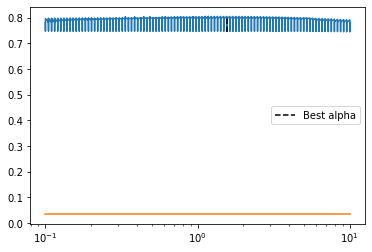

In [79]:
import matplotlib.pyplot as plt
ax = plt.gca()
ax.plot(cv_res.param_alpha, cv_res.mean_test_score,
        [10**min_alpha_log, 10**max_alpha_log], [baseline_err, baseline_err])
ax.set_xscale('log')
ax.vlines(
    best_params["alpha"],
    cv_res.mean_test_score.min(),
    cv_res.mean_test_score.max(),
    color="black",
    linestyle="--",
    label="Best alpha",
)
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


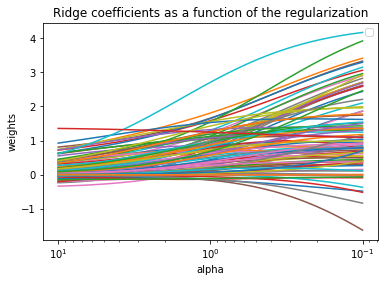

In [80]:
# cf. https://scikit-learn.org/stable/auto_examples/linear_model/plot_ridge_path.html

import warnings
with warnings.catch_warnings():
    alphas = np.logspace(min_alpha_log, max_alpha_log, n_alphas)

    coefs = []
    for a in alphas:
        ridge = linear_model.Ridge(alpha=a, fit_intercept=False)
        ridge.fit(X, y)
        coefs.append(ridge.coef_[0])

    #coefs = np.vstack(coefs)
    #flat_coefs = np.ravel(coefs)
    #display(coefs)


    ax = plt.gca()
    ax.plot(alphas, coefs)
    """ax.vlines(
        best_params["alpha"],
        #flat_coefs.min(),
        #flat_coefs.max(),
        color="black",
        linestyle="--",
        label="Best alpha",
    )"""

    ax.set_xscale("log")
    ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
    plt.xlabel("alpha")
    plt.ylabel("weights")
    plt.title("Ridge coefficients as a function of the regularization")
    plt.axis("tight")
    plt.legend()

    plt.show()

In [81]:
print_subtitle('Cross validated results :')  # TODO : mieux vaut un graphique + une sauvegarde
display(cv_res.sort_values(by='rank_test_score'))


Cross validated results :


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_random_state,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
414,0.008801,0.001165,0.004199,0.000399,1.555676,42,svd,"{'alpha': 1.5556761439304723, 'random_state': ...",0.786145,0.787797,0.818197,0.823107,0.806174,0.804284,0.015181,1
413,0.007000,0.001264,0.003400,0.000802,1.555676,42,auto,"{'alpha': 1.5556761439304723, 'random_state': ...",0.786145,0.787797,0.818197,0.823107,0.806174,0.804284,0.015181,2
418,0.004801,0.000981,0.003198,0.000400,1.555676,42,cholesky,"{'alpha': 1.5556761439304723, 'random_state': ...",0.786145,0.787797,0.818197,0.823107,0.806174,0.804284,0.015181,2
421,0.008201,0.001467,0.003598,0.001021,1.629751,42,svd,"{'alpha': 1.6297508346206444, 'random_state': ...",0.786131,0.788372,0.817911,0.823031,0.805951,0.804279,0.014984,4
420,0.005801,0.000748,0.003599,0.000800,1.629751,42,auto,"{'alpha': 1.6297508346206444, 'random_state': ...",0.786131,0.788372,0.817911,0.823031,0.805951,0.804279,0.014984,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669,0.219600,0.045124,0.004001,0.001095,8.302176,42,saga,"{'alpha': 8.302175681319747, 'random_state': 4...",0.728993,0.758009,0.726994,0.772049,0.742344,0.745678,0.017240,696
676,0.183400,0.022579,0.003800,0.001165,8.69749,42,saga,"{'alpha': 8.697490026177835, 'random_state': 4...",0.728967,0.757715,0.726933,0.771988,0.742106,0.745542,0.017207,697
683,0.170599,0.013186,0.002800,0.000749,9.111628,42,saga,"{'alpha': 9.111627561154895, 'random_state': 4...",0.728842,0.757647,0.726869,0.771923,0.741900,0.745436,0.017224,698
690,0.167608,0.018920,0.002592,0.000484,9.545485,42,saga,"{'alpha': 9.545484566618342, 'random_state': 4...",0.728811,0.757575,0.726801,0.771854,0.741786,0.745366,0.017218,699


##### Recherche en grille intégrée

In [82]:
reg = linear_model.RidgeCV(alphas=np.logspace(-5, 15, 100)) #, store_cv_values=True)
reg.fit(X_train, y_train)

print('best', bold('alpha'), ':', reg.alpha_)
print('best', bold('n-MSE score'), ':', reg.best_score_)
print(' train', bold('r2 score'), ':', reg.score(X_train, y_train))
print('  test', bold('r2 score'), ':', reg.score(X_test, y_test))
print('global', bold('r2 score'), ':', reg.score(X, y))

from seattle_commons import show_ols_scores # TODO : à renommer
show_ols_scores(reg, X, y, cv=3)

# display(reg.cv_values_)


best alpha : 1.7886495290574351
best n-MSE score : -0.23831166233236192
 train r2 score : 0.838578941170232
  test r2 score : 0.8032742610365003
global r2 score : 0.8117225558488184
cv scores : [0.83291188 0.74317997 0.79444033]
mean scores : 0.7901773938518061
std scores : 0.03675670825229613


## Config 18 : $\ln{e} = f(\ln{a}, \ln{n_l}, n_\star, (\tilde{a}_{u_k}), T, t_p, t_B)$

Config avec $t_b$ non abstrait ($t_B$) réduite au cas non résidentiel.

$\{t_B, t_p, T, \log(n_l), (\tilde{a}_{u_k}), n_\star, \log(a):\log(e)\}$

$R^2_{18, \text{Ridge}} \left(\{t_B, t_p, T, (\tilde{a}_{u_k}), n_\star, \log(n_l), \log(a):\log(e)\}\right)$ :
* $\mu = 0.7915945390339455$
* $\sigma = 0.03590629799802996$

#### Jeu de données

In [83]:
config_name = "{t_B, t_p, T, (_a_u_k)_k, n_★, log(n_l), log(a) : log(e)}"

from seattle_commons import get_ml_data_cfg
ml_data = get_ml_data_cfg(data, config_name); display(ml_data)

,btype_NonResidential,btype_Multifamily LR (1-4),btype_Multifamily MR (5-9),btype_Multifamily HR (10+),btype_Nonresidential COS,btype_Campus,btype_SPS-District K-12,btype_Nonresidential WA,ptype_Low-Rise Multifamily,ptype_Mid-Rise Multifamily,...,_ua_Fast Food Restaurant,_ua_Swimming Pool,_ua_Outpatient Rehabilitation/Physical Therapy,_ua_Single Family Home,_ua_Energy/Power Station,_ua_Vocat,star_score,log(n_l),log(a),log(e)
id,,,,,,,,,,,,,,,,,,,,,
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,60.0,2.564949,11.390012,15.793246
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,61.0,2.484907,11.547964,15.942305
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,43.0,3.737670,13.770628,18.100297
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,56.0,2.397895,11.023861,15.731636
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,75.0,2.944439,12.075850,16.466822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50221,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,72.0,0.693147,9.812523,13.745176
50223,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,72.0,0.693147,9.680344,13.764508
50224,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,72.0,0.693147,9.484709,15.567471


#### Visualisation

Trop de variables pour la visualisation.

In [84]:
from seattle_commons import check_data
check_data(ml_data)

✘ Negative coefficients :


,btype_NonResidential,btype_Multifamily LR (1-4),btype_Multifamily MR (5-9),btype_Multifamily HR (10+),btype_Nonresidential COS,btype_Campus,btype_SPS-District K-12,btype_Nonresidential WA,ptype_Low-Rise Multifamily,ptype_Mid-Rise Multifamily,...,_ua_Fast Food Restaurant,_ua_Swimming Pool,_ua_Outpatient Rehabilitation/Physical Therapy,_ua_Single Family Home,_ua_Energy/Power Station,_ua_Vocat,star_score,log(n_l),log(a),log(e)
id,,,,,,,,,,,,,,,,,,,,,
32,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,-0.003151,0.000000,0.0,0.000000,0.0,62.0,2.197225,11.974620,15.488496
43,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,-1.376086,0.0,8.0,1.386294,13.111980,19.921163
100,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,96.0,1.791759,12.664465,16.439886
234,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,60.0,1.098612,10.825601,12.972641
238,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,73.0,1.098612,11.420042,16.063888
247,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,55.5,1.098612,12.096040,16.060086
248,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,60.0,1.098612,10.979172,15.183818
264,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,75.0,1.609438,11.615347,16.172386
265,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,85.0,2.079442,11.669476,16.122100


✔ No NA coefficient


#### Partition

In [85]:
from seattle_commons import features_target_split
X, y = features_target_split(ml_data)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

#### Entraînement

##### Recherche en grille externe

In [86]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    lr = linear_model.LinearRegression()
    lr_reg = lr.fit(X_train, y_train)
    baseline_err = cross_val_score(lr_reg, X_train, y_train, cv=5).mean()
    print(baseline_err)

-0.12786498116618467


In [87]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from pepper_commons import print_title, print_subtitle, bold
import time
from pepper_skl_commons import Dataset, get_baseline_err, search_best_params, get_best_params

Xy = X_train, X_test, y_train, y_test
model = linear_model.Ridge()
min_alpha_log = -1
max_alpha_log = 1
n_alphas = 100

param_grid = {
    'alpha': np.logspace(min_alpha_log, max_alpha_log, n_alphas),
    'solver': ['auto', 'svd', 'sparse_cg', 'sag', 'saga', 'cholesky', 'lsqr'], #, 'lbfgs'
    'random_state': [42]
}

best_estimator = best_params = best_score = best_index = scorer = cv_res = None
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    (
        best_estimator,
        best_params,
        best_score,
        best_index,
        scorer,
        cv_res
    ) = get_best_params(Xy, model, param_grid, baseline_err, cv=5, verbose=False)

coucoukookoo


In [88]:
import warnings
with warnings.catch_warnings():
    print('best', bold('estimator'), ':', best_estimator)
    print('best', bold('params'), ':', best_params)
    print('best', bold('score'), ':', best_score)
    print('best', bold('index'), ':', best_index)
    print(bold('scorer'), ':', scorer)

    print(' train', bold('score'), ':', best_estimator.score(X_train, y_train))
    print('  test', bold('score'), ':', best_estimator.score(X_test, y_test))
    print('global', bold('score'), ':', best_estimator.score(X, y))

    print('best', bold('estimator'), 'intercept :', best_estimator.intercept_)
    print('best', bold('estimator'), '    coefs :', best_estimator.coef_)

    from seattle_commons import show_ols_scores # TODO : à renommer
    show_ols_scores(best_estimator, X, y, cv=3)

best estimator : Ridge(alpha=1.484968262254465, random_state=42, solver='sparse_cg')
best params : {'alpha': 1.484968262254465, 'random_state': 42, 'solver': 'sparse_cg'}
best score : 0.8060113808432275
best index : 408
scorer : <function _passthrough_scorer at 0x000001D792EEA790>
 train score : 0.8388686874857249
  test score : 0.8076079198201027
global score : 0.8150970828386344
best estimator intercept : 4.431311850613373
best estimator     coefs : [ 5.84999898e-02 -2.95300153e-01 -2.32603568e-01 -2.19228233e-01
  3.29204585e-01  3.81113939e-01 -2.16865600e-02  0.00000000e+00
 -3.33815488e-01 -2.67727215e-01 -1.28444730e-01  2.25238167e-01
 -2.49594050e-01 -7.75447289e-02 -8.34004574e-02 -2.19228233e-01
 -6.44186561e-02  1.62650357e-01 -1.91523419e-01 -4.53929896e-01
  2.09584257e-02  7.18331317e-02  6.67128834e-02  5.46876306e-01
 -6.76353823e-01  5.19499901e-02 -3.96236966e-03  1.55929558e-01
  5.34256382e-01  5.17600017e-01  3.95937848e-01  8.76419091e-04
  3.48340872e-01  2.7590

In [89]:
print_subtitle('Cross validated results :')  # TODO : mieux vaut un graphique + une sauvegarde
display(cv_res.sort_values(by='rank_test_score'))


Cross validated results :


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_random_state,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
408,0.007002,0.000633,0.003398,0.001020,1.484968,42,sparse_cg,"{'alpha': 1.484968262254465, 'random_state': 4...",0.785753,0.796486,0.821244,0.822735,0.803838,0.806011,0.014266,1
401,0.008000,0.000634,0.003999,0.000633,1.417474,42,sparse_cg,"{'alpha': 1.4174741629268055, 'random_state': ...",0.785844,0.796031,0.821485,0.822753,0.803941,0.806011,0.014355,2
415,0.008801,0.001169,0.003999,0.000004,1.555676,42,sparse_cg,"{'alpha': 1.5556761439304723, 'random_state': ...",0.785646,0.796970,0.820992,0.822715,0.803716,0.806008,0.014179,3
394,0.007601,0.000491,0.004602,0.000491,1.353048,42,sparse_cg,"{'alpha': 1.3530477745798075, 'random_state': ...",0.785945,0.795564,0.821715,0.822774,0.804026,0.806005,0.014445,4
422,0.010599,0.000489,0.004599,0.000801,1.629751,42,sparse_cg,"{'alpha': 1.6297508346206444, 'random_state': ...",0.785528,0.797439,0.820723,0.822701,0.803576,0.805993,0.014099,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669,0.202801,0.021442,0.002599,0.000800,8.302176,42,saga,"{'alpha': 8.302175681319747, 'random_state': 4...",0.730211,0.759109,0.729792,0.774647,0.742851,0.747322,0.017353,696
676,0.192000,0.026958,0.002800,0.000748,8.69749,42,saga,"{'alpha': 8.697490026177835, 'random_state': 4...",0.730067,0.759055,0.729733,0.774586,0.742739,0.747236,0.017373,697
683,0.200799,0.027475,0.003801,0.000748,9.111628,42,saga,"{'alpha': 9.111627561154895, 'random_state': 4...",0.730032,0.758998,0.729671,0.774353,0.742478,0.747107,0.017325,698
690,0.226199,0.011495,0.003401,0.000489,9.545485,42,saga,"{'alpha': 9.545484566618342, 'random_state': 4...",0.729995,0.758738,0.729606,0.774285,0.742193,0.746964,0.017304,699


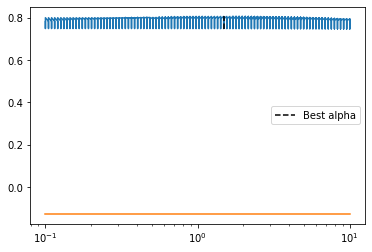

In [90]:
import matplotlib.pyplot as plt
ax = plt.gca()
ax.plot(cv_res.param_alpha, cv_res.mean_test_score,
        [10**min_alpha_log, 10**max_alpha_log], [baseline_err, baseline_err])
ax.set_xscale('log')
ax.vlines(
    best_params["alpha"],
    cv_res.mean_test_score.min(),
    cv_res.mean_test_score.max(),
    color="black",
    linestyle="--",
    label="Best alpha",
)
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


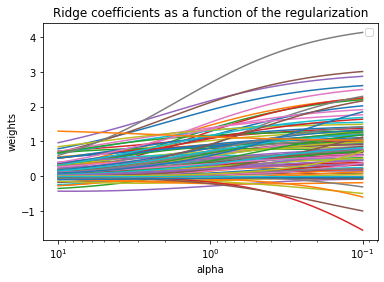

In [91]:
# cf. https://scikit-learn.org/stable/auto_examples/linear_model/plot_ridge_path.html

import warnings
with warnings.catch_warnings():
    alphas = np.logspace(min_alpha_log, max_alpha_log, n_alphas)

    coefs = []
    for a in alphas:
        ridge = linear_model.Ridge(alpha=a, fit_intercept=False)
        ridge.fit(X, y)
        coefs.append(ridge.coef_[0])

    #coefs = np.vstack(coefs)
    #flat_coefs = np.ravel(coefs)
    #display(coefs)


    ax = plt.gca()
    ax.plot(alphas, coefs)
    """ax.vlines(
        best_params["alpha"],
        #flat_coefs.min(),
        #flat_coefs.max(),
        color="black",
        linestyle="--",
        label="Best alpha",
    )"""

    ax.set_xscale("log")
    ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
    plt.xlabel("alpha")
    plt.ylabel("weights")
    plt.title("Ridge coefficients as a function of the regularization")
    plt.axis("tight")
    plt.legend()

    plt.show()

In [92]:
print_subtitle('Cross validated results :')  # TODO : mieux vaut un graphique + une sauvegarde
display(cv_res.sort_values(by='rank_test_score'))


Cross validated results :


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_random_state,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
408,0.007002,0.000633,0.003398,0.001020,1.484968,42,sparse_cg,"{'alpha': 1.484968262254465, 'random_state': 4...",0.785753,0.796486,0.821244,0.822735,0.803838,0.806011,0.014266,1
401,0.008000,0.000634,0.003999,0.000633,1.417474,42,sparse_cg,"{'alpha': 1.4174741629268055, 'random_state': ...",0.785844,0.796031,0.821485,0.822753,0.803941,0.806011,0.014355,2
415,0.008801,0.001169,0.003999,0.000004,1.555676,42,sparse_cg,"{'alpha': 1.5556761439304723, 'random_state': ...",0.785646,0.796970,0.820992,0.822715,0.803716,0.806008,0.014179,3
394,0.007601,0.000491,0.004602,0.000491,1.353048,42,sparse_cg,"{'alpha': 1.3530477745798075, 'random_state': ...",0.785945,0.795564,0.821715,0.822774,0.804026,0.806005,0.014445,4
422,0.010599,0.000489,0.004599,0.000801,1.629751,42,sparse_cg,"{'alpha': 1.6297508346206444, 'random_state': ...",0.785528,0.797439,0.820723,0.822701,0.803576,0.805993,0.014099,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669,0.202801,0.021442,0.002599,0.000800,8.302176,42,saga,"{'alpha': 8.302175681319747, 'random_state': 4...",0.730211,0.759109,0.729792,0.774647,0.742851,0.747322,0.017353,696
676,0.192000,0.026958,0.002800,0.000748,8.69749,42,saga,"{'alpha': 8.697490026177835, 'random_state': 4...",0.730067,0.759055,0.729733,0.774586,0.742739,0.747236,0.017373,697
683,0.200799,0.027475,0.003801,0.000748,9.111628,42,saga,"{'alpha': 9.111627561154895, 'random_state': 4...",0.730032,0.758998,0.729671,0.774353,0.742478,0.747107,0.017325,698
690,0.226199,0.011495,0.003401,0.000489,9.545485,42,saga,"{'alpha': 9.545484566618342, 'random_state': 4...",0.729995,0.758738,0.729606,0.774285,0.742193,0.746964,0.017304,699


##### Recherche en grille intégrée

In [93]:
reg = linear_model.RidgeCV(alphas=np.logspace(-5, 15, 100)) #, store_cv_values=True)
reg.fit(X_train, y_train)

print('best', bold('alpha'), ':', reg.alpha_)
print('best', bold('n-MSE score'), ':', reg.best_score_)
print(' train', bold('r2 score'), ':', reg.score(X_train, y_train))
print('  test', bold('r2 score'), ':', reg.score(X_test, y_test))
print('global', bold('r2 score'), ':', reg.score(X, y))

from seattle_commons import show_ols_scores # TODO : à renommer
show_ols_scores(reg, X, y, cv=3)

# display(reg.cv_values_)


best alpha : 1.7886495290574351
best n-MSE score : -0.23674474720768676
 train r2 score : 0.8413581609167572
  test r2 score : 0.8081018740704596
global r2 score : 0.8160630940702509
cv scores : [0.83638046 0.74847577 0.78992739]
mean scores : 0.7915945390339455
std scores : 0.03590629799802996
